A continuous challenge for owners of Q&A sites is to maintain a decent level of quality in the posted content. Sites such as StackOverflow make considerable effort to encourage users with diverse possibilities to score content, and offer badges and bonus points to spend more energy on carving out the question or crafting a possible answer.

One particularly successful incentive is the ability for the asker to flag one answer to their question as the accepted answer (there are incentives for the asker to flag answers as such). This will result in a higher score for the author of the flagged answer

Would it not be very useful for the user to immediately see how good their answer is while typing it in? This will
encourage the user to put more effort into writing the answer (such as providing a code example or even including an image), and thus improve the overall system.

# Learning to classify classy answers

In classification, the goal is to find the corresponding classes, sometimes also called labels, for given data instances. To be able to achieve this, two questions need to be answered:
* How should the data instances is represented?
* Which model or structure should the classifier possess?

## Tuning the instance

In its simplest form, in this case the data instance is the answer text itself and the label would be a binary value indicating whether the asker accepted this text as an answer or not. Raw text, however, is a very inconvenient representation to process for most machine learning algorithms. And it will be the next task to extract useful features from the raw text, which the machine learning algorithm can then use to learn the right label for it.

## Tuning the classifier

Once enough (text, label) pairs have been found or collected, a classifier can be trained. In this notebook, the instance-based method, nearest-neighbor, with model-based logistic regression will be contrasted.

# Fetching the data

Luckily, the team behind StackOverflow provides most of the data behind the StackExchange universe to which StackOverflow belongs under a cc-by-sa license. At the time of writing this notebook, the latest data dump can be found at https://archive.org/download/stackexchange. For StackOverflow, there are multiple files, of which the file that will be only needed is stackoverflow.com-Posts.7z, which is 11.3 GB.

After downloading and extracting it, it has around 59 GB of data in the XML format, containing all questions and answers as individual row tags within the root tag posts:

# ![Posts](./Posts.PNG)

Refer to the following table:

| **Name**         | **Type**         | **Description**                                                                                                                               |
|------------------|------------------|-----------------------------------------------------------------------------------------------------------------------------------------------|
| Id               | Integer          | This is a unique identifier of the post.                                                                                                      |
| PostTypeId       | Integer          | This describes the category of the post. The values of interest to us are the following:  1: Question 2: Answer Other values will be ignored. |
| ParentId         | Integer          | This is a unique identifier of the question to which this answer belongs. It is missing for questions, in which case we will set it to -1.    |
| CreationDate     | DateTime         | This is the date of submission.                                                                                                               |
| Score            | Integer          | This is the score of the post.                                                                                                                |
| ViewCount        | Integer or empty | This is the number of user views for this post.                                                                                               |
| Body             | String           | This is the complete post as encoded HTML text.                                                                                               |
| OwnerUserId      | Id               | This is a unique identifier of the poster. If 1, then it is a wiki question.                                                                  |
| Title            | String           | This is the title of the question (missing for answers).                                                                                      |
| AcceptedAnswerId | Id               | This is the ID for the accepted answer (missing for answers).                                                                                 |
| CommentCount     | CommentCount     | CommentCount

Try to stick to the Python style guides for variable naming. In this chapter, the names in the XML fomat will be used so they are easier to follow. For example, choose ParentId instead of parent_id.

## Slimming the data down to chewable chunks

Many variants will be needed to train, until the final classifier. Given the current data, it will be slowed down considerably by the following:
* Post-it stores attributes, which we might not need.
* It is stored as XML, which is not the fastest format to parse.
* The dump contains posts that date back to 2011. Restricting to just the year 2017, we will still end up with over 6,000,000 posts, which should be enough.

## Preselecting and processing attributes

Attributes that will not help the classifier in distinguishing between good and not-so-good answers can be certainly dropped. Although some features do not directly impact the classification, they are still necessary to keep:
* The PostTypeId attribute, for example, is necessary to distinguish between questions and answers. It will not be picked to serve as a feature, but it will be needed to filter the data.
* CreationDate could be interesting to determine the time span between posting the question and posting the individual answers. In this notebook, however, it will be ignored.
* Score is important as an indicator of the community's evaluation.
* ViewCount, in contrast, is most likely of no use for this task. So it is ignored.
* The Body attribute obviously contains the most important information. As it is encoded HTML, it will have to be decoded to plain text.
* OwnerUserId is only useful if we take user-dependent features into account, which it won't be.
* The Title attribute is also ignored here, although it could add some more information about the question.
* CommentCount is also ignored. Similar to ViewCount, it could help the classifier with posts that are out there for a while (more comments = more ambiguous post?). It will, however, not help the classifier at the time an answer is posted.
* AcceptedAnswerId is similar to Score in that it is an indicator of a post's quality. Since the score is already exist, the acceptance information will be ignored.

Suffice to say that in order to speed up processing, the lxml module will be used to parse the XML file and then output two files. In one file, a dictionary that maps a post's Id value to its other data will be stored, except Text in the JSON format, so that it can be read easily and kept in memory in the meta dictionary. For example, the score of a post would reside at meta[post_id]['Score']. The same will be done for the new features that will be created throughout this notebook.

The actual posts will be then stored in another tab-separated file, where the first column is Id and the second one is Text, which it can be easily read with the following method:

In [1]:
def fetch_posts(fn):
    for line in open(fn, "r", encoding="utf8"):
        post_id, text = line.split("\t")
        yield int(post_id), text.strip()

The two files are called as follows:

In [2]:
import os
import re

DATA_DIR = 'YOUR_DATA_DIR'

YEAR = 2021

fn_posts_all = os.path.join(DATA_DIR, "Posts.xml")
fn_posts = os.path.join(DATA_DIR, "posts-{}.xml".format(YEAR))

fn_filtered = os.path.join(DATA_DIR, "filtered-{}.tsv".format(YEAR))
fn_filtered_meta = os.path.join(DATA_DIR, "filtered-{}-meta.json".format(YEAR))

SAMPLE_DIR = os.path.join(DATA_DIR, str(YEAR))
if not os.path.exists(SAMPLE_DIR):
    os.mkdir(SAMPLE_DIR)

if not os.path.exists(os.path.join(SAMPLE_DIR, 'data')):
    os.mkdir(os.path.join(SAMPLE_DIR, 'data'))

fn_sample = os.path.abspath(os.path.join(SAMPLE_DIR, 'data', "sample.tsv"))
fn_sample_meta = os.path.abspath(os.path.join(SAMPLE_DIR, 'data', "sample-meta.json"))
print("sample posts: {}".format(fn_sample))
print("sample meta: {}".format(fn_sample_meta))

CHART_DIR = os.path.join(SAMPLE_DIR, "charts")
if not os.path.exists(CHART_DIR):
    os.mkdir(CHART_DIR)

year_match = re.compile(r'^\s+<row [^>]*CreationDate="(\d+)-')
size = os.path.getsize(fn_posts_all)

def get_year(line):
    m = year_match.match(line)
    if m is None:
        return None
    return int(m.group(1))

print("Extracting all posts from {} ...".format(YEAR))
with open(fn_posts_all, 'r', encoding='utf-8') as fa, open(fn_posts, 'w', encoding='utf-8') as f_year:
    # first two lines are the xml header and <posts> tag
    f_year.write('<?xml version="1.0" encoding="utf-8"?><posts>\n')

    right = size//2
    delta = right

    # first find some post of YEAR
    while True:
        fa.seek(right)
        fa.readline() # go to next newline
        line = fa.readline()
        
        year = get_year(line)
        
        delta //= 2
        assert delta > 0
        
        if year > YEAR:
            right -= delta
        elif year < YEAR:
            right += delta
        else:
            break
    
    # then find where it starts
    left = right//2
    delta = left
    while True:
        fa.seek(left)
        fa.readline() # go to next newline
        line = fa.readline()
        
        year = get_year(line)
        
        delta //= 2
        if delta == 0:
            break
        
        if year<YEAR:
            left += delta
        else:
            left, right = left-delta, left
    
    # and write all posts of that year
    while True:
        line = fa.readline()
        year = get_year(line)
        if year == YEAR:
            f_year.write(line)
        elif year is None or year > YEAR:
            break

    # and write the closing tag
    f_year.write('</posts>')
print('... done!')

sample posts: c:\Users\robit\Downloads\data\2021\data\sample.tsv
sample meta: c:\Users\robit\Downloads\data\2021\data\sample-meta.json
Extracting all posts from 2021 ...
... done!


## Defining what a good answer is

Before a classifier can be trained to distinguish between good and bad answers, the training data has to be created. The labels still need to be defined.

Of course, the best and worst-scoring answer per question could be simply taken as positive and negative examples. However, what about with questions that have only good answers, say, one with two and the other with four points? Should the answer with two points is really taken as a negative example just because it happened to be the one with the lower score? Or let's say that it has only two negative answers, one with a score of -2 and the other with -4. Clearly, the answer with -2 cannot be taken as a positive example.

Therefore look for answers that have at least an answer with a score higher than 0 and at least one with a negative score and throw away those that don't fit this criterion. If the remaining data is taken all, it is needed to wait quite some time at every step, so filter down further to 10,000 questions. From those, the highest-scoring answer will be picked as the positive example and the lowest-scoring answer as a negative one, which results into 20,000 answers for the training set.

As mentioned earlier, throughout this notebook, a meta dictionary will be maintained, which maps the answer IDs to the features, of which score is one (more features will be designed along the way). Therefore, the labels can be created as follows:

In [3]:
from operator import itemgetter
from lxml import etree
from tqdm.notebook import tqdm as tqdm
try:
    import ujson as json  # UltraJSON if available
except:
    print("You can also use the normal json module, but you get a XXX speedup if you use ujson instead.")
    raise
from collections import defaultdict
import numpy as np

NUM_ROWS = 3739566 # counted by hand

filtered_meta = {
    'question': {}, # question -> [(answer Id, Score), ...]
    'total': 0 # questions and answers finally written
}

# Regular expressions to find code snippets, links, and tags, which might help in 
# designing useful features
code_match = re.compile('<pre>(.*?)</pre>', re.MULTILINE | re.DOTALL)
link_match = re.compile('<a href="http://.*?".*?>(.*?)</a>', re.MULTILINE | re.DOTALL)
tag_match = re.compile('<[^>]*>', re.MULTILINE | re.DOTALL)
whitespace_match = re.compile(r'\s+', re.MULTILINE | re.DOTALL)

def extract_features_from_body(s):
    '''
    This method creates features from the raw post. It already contains all 
    features that we will use throughout the chapter.
    '''
    num_code_lines = 0
    link_count_in_code = 0
    code_free_s = s

    # remove source code and count how many lines
    for match_str in code_match.findall(s):
        num_code_lines += match_str.count('\n')
        code_free_s = code_match.sub(' ', code_free_s)

        # sometimes source code contain links, which we don't want to count
        link_count_in_code += len(link_match.findall(match_str))

    links = link_match.findall(s)
    link_count = len(links) - link_count_in_code

    html_free_s = tag_match.sub(' ', code_free_s)
    
    text = html_free_s
    for link in links:
        if link.lower().startswith('http://'):
            text = text.replace(link, ' ')

    text = whitespace_match.sub(' ', text)
    num_text_tokens = text.count(' ')

    return text, num_text_tokens, num_code_lines, link_count

num_questions = 0
num_answers = 0

def parsexml(fn):
    global num_questions, num_answers

    counter = 0

    # iterparse() returns a tuple (event, element). Since we request only
    # 'start' events, we pipe the result through an itemgetter that always returns
    # the 2nd result.
    it = map(itemgetter(1), etree.iterparse(fn, events=('start',)))
    
    # Get the <posts> element, in which we will parse the <row> elements. While doing so,
    # we will need the root handle to clear memory
    root = next(it)
    
    for counter, elem in enumerate(tqdm(it, total=NUM_ROWS)):
        
        if elem.tag != 'row':
            continue
            
        Id = int(elem.get('Id'))
        PostTypeId = int(elem.get('PostTypeId'))
        Score = int(elem.get('Score'))

        if PostTypeId == 1:
            num_questions += 1            
            ParentId = -1
            filtered_meta['question'][Id] = []
            
        elif PostTypeId == 2:
            num_answers += 1
            ParentId = int(elem.get('ParentId'))
            if not ParentId in filtered_meta['question']:
                # question is not from the same year so we have already dropped it
                continue

            filtered_meta['question'][ParentId].append((Id, Score))

        else:
            continue

        Text, NumTextTokens, NumCodeLines, LinkCount = extract_features_from_body(elem.get('Body'))

        # We have to tell lxml that this element is not used anymore. Otherwise, memory will blow up.
        # See https://www.ibm.com/developerworks/xml/library/x-hiperfparse for more information.
        elem.clear()
        while elem.getprevious() is not None:
            del elem.getparent()[0]
            
        values = (Id, ParentId, Score, NumTextTokens, NumCodeLines, LinkCount, Text)

        yield values

    print("Found {} posts".format(counter))

if any(not os.path.exists(fn) for fn in [fn_filtered, fn_filtered_meta]):
    total = 0
    with open(fn_filtered, "w", encoding='utf-8') as f:
        for values in parsexml(fn_posts):
            line = "\t".join(map(str, values))
            f.write(line + "\n")
            total += 1
    filtered_meta['total'] = total
                
    with open(fn_filtered_meta, "w") as f:
        json.dump(filtered_meta, f)
    
    print("#qestions: {}".format(num_questions))
    print("#answers: {}".format(num_answers))
    
else:
    print("Skipping the conversion step, loading data from {} ...".format(fn_filtered_meta))
    filtered_meta = json.load(open(fn_filtered_meta, "r"))
    print("... done!")

NUM_QUESTION_SAMPLE = 10000

posts_to_keep = set()
found_questions = 0

question = filtered_meta['question']

# Sorting the questions before iterating over them is only done for
# reproducability.
for ParentId, posts in tqdm(sorted(question.items()), desc="Stage 1:"):
    assert ParentId != -1

    if len(posts) < 2:
        continue

    neg_score_ids = []
    pos_score_ids = []
    
    for Id, Score in posts:
        if Score < 0:
            neg_score_ids.append((Score, Id))
        elif Score > 0:
            pos_score_ids.append((Score, Id))   

    if pos_score_ids and neg_score_ids:
        posts_to_keep.add(int(ParentId))

        posScore, posId = sorted(pos_score_ids)[-1]
        posts_to_keep.add(posId)

        negScore, negId = sorted(neg_score_ids)[0]
        posts_to_keep.add(negId)

        found_questions += 1

    if found_questions >= NUM_QUESTION_SAMPLE:
        break

already_written = set()
sample_meta = defaultdict(dict)

total = 0
kept = 0

with open(fn_sample, "w", encoding='utf-8') as f:
    for line in tqdm(open(fn_filtered, 'r', encoding='utf-8'), total=NUM_ROWS, desc="Stage 2:"):
        Id, ParentId, Score, NumTextTokens, NumCodeLines, LinkCount, Text = line.split("\t")

        Text = Text.strip()

        total += 1

        Id = int(Id)
        if Id in posts_to_keep:
            if Id in already_written:
                print(Id, "is already written")
                continue

            # setting meta info
            post = sample_meta[Id]
            post['ParentId'] = int(ParentId)
            post['Score'] = int(Score)
            post['NumTextTokens'] = int(NumTextTokens)
            post['NumCodeLines'] = int(NumCodeLines)
            post['LinkCount'] = int(LinkCount)
            post['idx'] = kept  # index into the TSV file

            if int(ParentId) == -1:
                q = sample_meta[Id]

                if not 'Answers' in q:
                    q['Answers'] = []

            else:
                q = sample_meta[int(ParentId)]

                if 'Answers' not in q:
                    q['Answers'] = [Id]
                else:
                    q['Answers'].append(Id)

            f.writelines("%s\t%s\n" % (Id, Text))
            kept += 1

with open(fn_sample_meta, "w") as fm:
    json.dump(sample_meta, fm)

print("read:", total)
print("kept:", kept)

def load_meta(fn):
    meta = json.load(open(fn, "r"))
    
    # JSON only allows string keys, changing that to int
    for key in list(meta.keys()):
        meta[int(key)] = meta[key]
        del meta[key]

    return meta

meta = load_meta(fn_sample_meta)

all_answers = [a for a,v in meta.items() if v['ParentId']!=-1]
Y = np.asarray([meta[aid]['Score'] > 0 for aid in all_answers])
print(np.unique(Y, return_counts=True))

  0%|          | 0/3739566 [00:00<?, ?it/s]

Found 3739563 posts
#qestions: 1727230
#answers: 2009252


Stage 1::   0%|          | 0/1727230 [00:00<?, ?it/s]

Stage 2::   0%|          | 0/3739566 [00:00<?, ?it/s]

read: 3358584
kept: 30000
(array([False,  True]), array([10000, 10000], dtype=int64))


# Creating the first classifier

Start with the simple and beautiful nearest-neighbor method. But this beauty comes with a clear disadvantage, which it will be found out very soon.

## Engineering the features

As mentioned earlier, the Text and Score features will be used to train the classifier. Start with the number of HTML links, assuming that good posts have a higher chance of having links in them.

This can be done with regular expressions. The following captures all HTML link tags that start with http:// (ignoring the other protocols for now):

In [4]:
import re

link_match = re.compile('<a href="http://.*?".*?>(.*?)</a>', re.MULTILINE | re.DOTALL)

However, links that are part of a code block is not counted. This can be done by another regular expression that matches the <'pre'> tag, which is used on the StackExchange sites to mark up code:

In [5]:
code_match = re.compile('<pre>(.*?)</pre>', re.MULTILINE | re.DOTALL)

def extract_features_from_body(s):
    link_count_in_code = 0
    # count links in code to later subtract them
    for match_str in code_match.findall(s):
        link_count_in_code += len(link_match.findall(match_str))
    return len(link_match.findall(s)) - link_count_in_code

For production systems, HTML content would not be parsed with regular expressions. Instead, excellent libraries is used such as BeautifulSoup, which does a marvelous job of robustly handling all the weird things that typically occur in everyday HTML.

With this in place, one feature per answer can be generated and stored in meta. A first impression can be obtained
with the frequency distribution of the new feature. This can be done by plotting the percentage of how often each value occurs in the data:

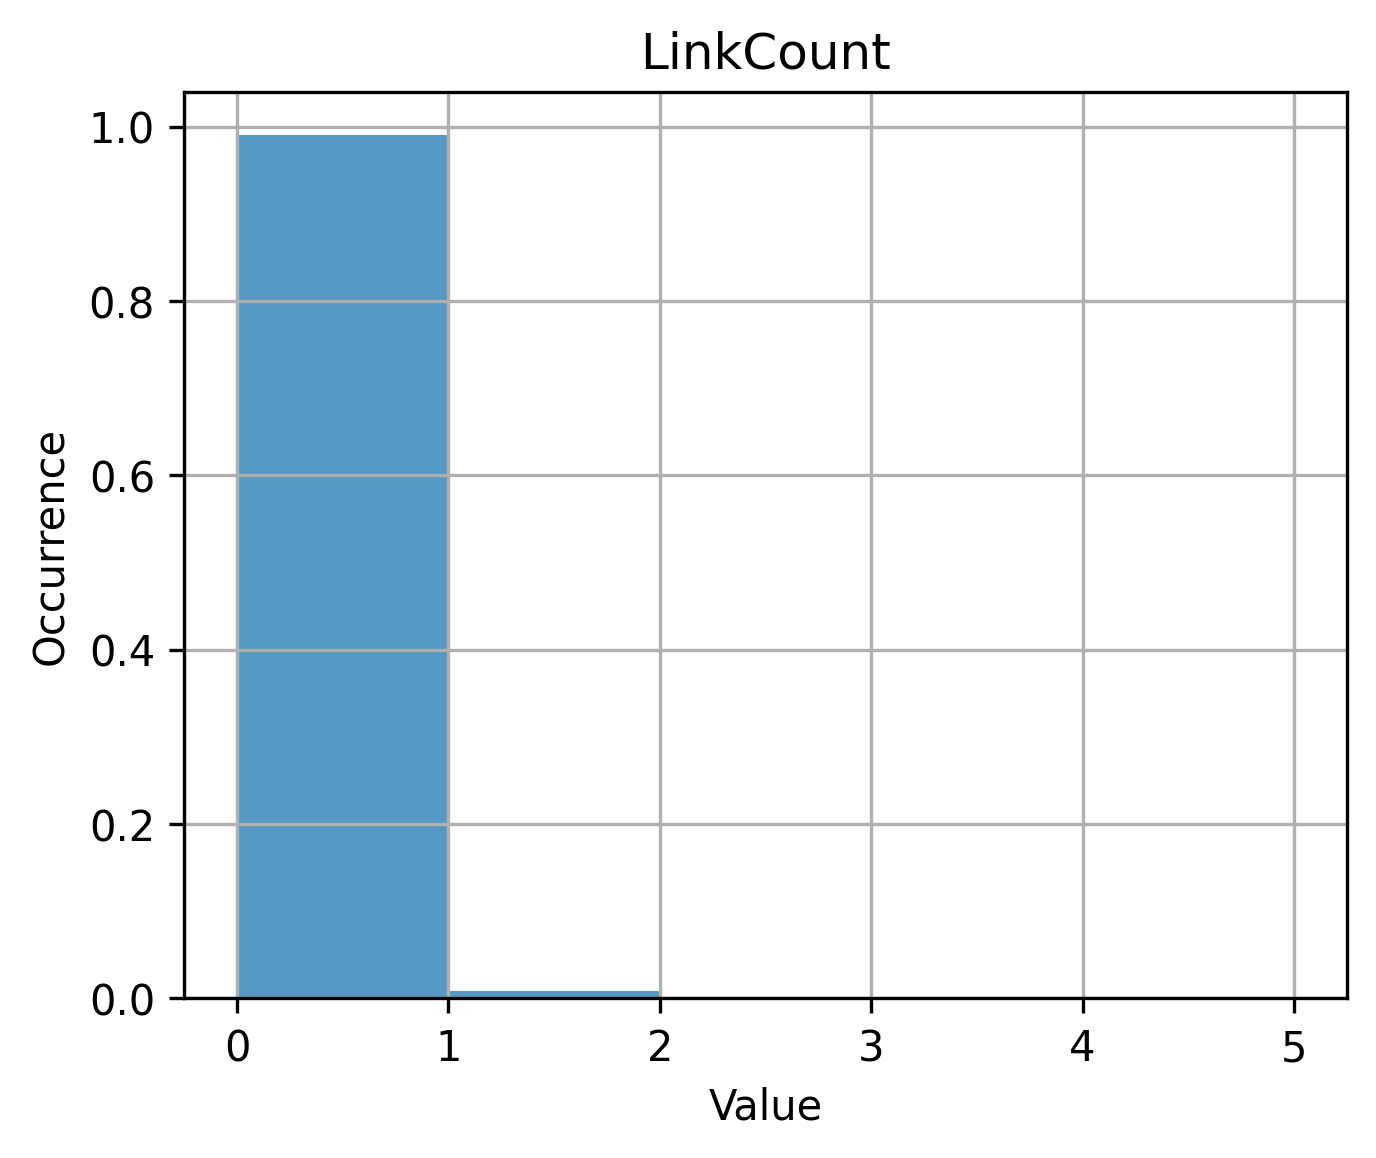

In [6]:
import matplotlib.pyplot as plt

X = np.asarray([[meta[aid]['LinkCount']] for aid in all_answers])
plt.figure(figsize=(5,4), dpi=300)
plt.title('LinkCount')
plt.xlabel('Value')
plt.ylabel('Occurrence')
n, bins, patches = plt.hist(X, density=1, bins=range(max(X.ravel()) - min(X.ravel())), alpha=0.75)
plt.grid(True)
plt.show()

With the majority of posts having no link at all, this feature will not make a good classifier. Try it out anyway to get a first estimation.

## Training the classifier

The feature array has to be passed together with the previously defined Y label to the kNN learner to obtain a classifier:

In [7]:
from sklearn.neighbors import KNeighborsClassifier

X = np.asarray([extract_features_from_body(text) for post_id, text in fetch_posts(fn_sample) if post_id in all_answers]).reshape(-1, 1)
knn = KNeighborsClassifier()
knn.fit(X, Y)

KNeighborsClassifier()

Using the standard parameters, a 5NN (meaning NN with k=5) was just fitted to the data. Once more insight is obtained, a better idea of how to set k will be obtained.

## Measuring the classifier's performance

It has to be clear about what it will be measured. The naïve, but easiest, way is to simply calculate the average prediction quality over the test set. This will result in a value between 0 for predicting everything wrongly and 1 for perfect prediction.

For now use the accuracy as the prediction quality, which scikit-learn conveniently calculates with knn.score(). It will not be done just once, but apply cross-validation here using the readymade KFold class from sklearn.model_selection. Finally, the scores on the test set of each fold will be averaged and see how much it varies using standard deviation:

In [8]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold

scores = []
N_FOLDS = 10
cv = KFold(n_splits=N_FOLDS, shuffle=True, random_state=0)
for train, test in cv.split(X, Y):
    X_train, y_train = X[train], Y[train]
    X_test, y_test = X[test], Y[test]
    clf =KNeighborsClassifier()
    clf.fit(X_train, y_train)
    scores.append(clf.score(X_test, y_test))
print("Mean(scores)={:.5f} \t Stddev(scores)={:.5f}".format(np.mean(scores), np.std(scores)))

Mean(scores)=0.49850 	 Stddev(scores)=0.00941


Now, that is far from being usable. So, the conclution is this feature does not have much discriminative power—at least not for kNN with k=5.

## Designing more features

In addition to using the number of hyperlinks as a proxy for a post's quality, the number of code lines is possibly another good one, too. And once it has been extracted, the number of normal words in the post should be counted:

In [9]:
# use regular expression to remove HTML tags
tag_match = re.compile('<[^>]*>', re.MULTILINE | re.DOTALL)
whitespace_match = re.compile(r'\s+', re.MULTILINE | re.DOTALL)

def extract_features_from_body(s):
    num_code_lines = 0
    link_count_in_code = 0
    # remove source code and count how many lines the post has
    code_free_s = s
    for match_str in code_match.findall(s):
        num_code_lines += match_str.count('\n')
        code_free_s = code_match.sub(' ', code_free_s)
        # Sometimes source code contains links, which we don't want to
        # count
        link_count_in_code += len(link_match.findall(match_str))
    links = link_match.findall(s)
    link_count = len(links) - link_count_in_code
    html_free_s = tag_match.sub(' ', code_free_s)
    text = html_free_s
    for link in links:
        if link.lower().startswith('http://'):
            text = text.replace(link, ' ')
    text = whitespace_match.sub(' ', text)
    num_text_tokens = text.count(' ')
    return num_text_tokens, num_code_lines, link_count

Looking at this, notice that at least the number of words in a post shows higher variability:

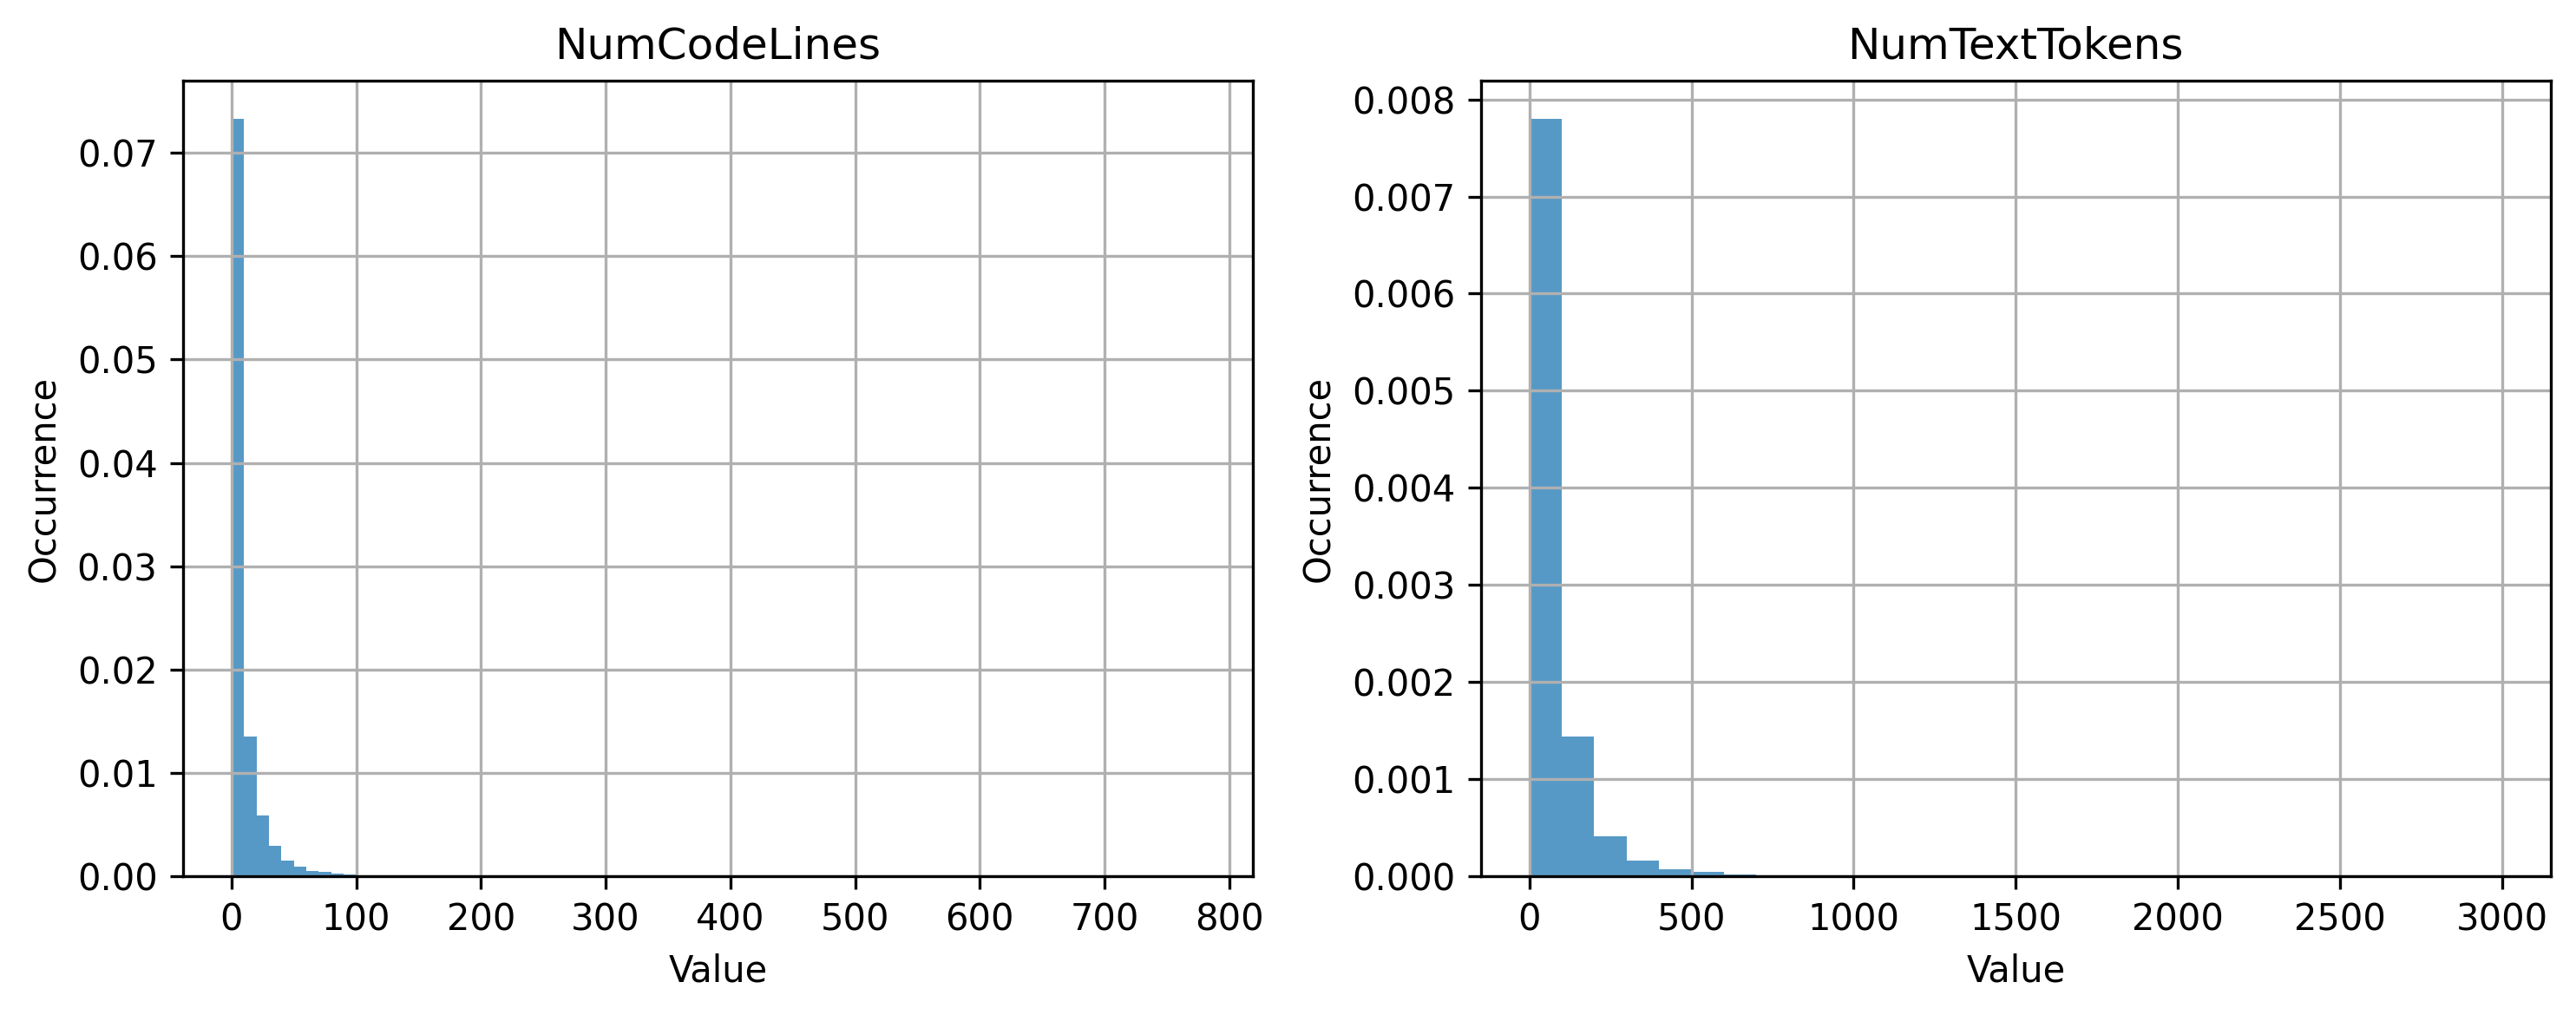

In [10]:
def plot_feat_hist(data_name_list, filename=None):
    if len(data_name_list) > 1:
        assert filename is not None

    num_rows = int(1 + (len(data_name_list) - 1) / 2)
    num_cols = int(1 if len(data_name_list) == 1 else 2)
    plt.figure(figsize=(5 * num_cols, 4 * num_rows), dpi=300)

    for i in range(num_rows):
        for j in range(num_cols):
            plt.subplot(num_rows, num_cols, 1 + i * num_cols + j)
            x, name = data_name_list[i * num_cols + j]
            plt.title(name)
            plt.xlabel('Value')
            plt.ylabel('Occurrence')
            
            max_val = max(x.ravel())
            if max_val>1000:
                bins = range(0, max_val, 100)
            elif max_val>100:
                bins = range(0, max_val, 10)
            else:
                bins = range(0, max_val)
            
            n, bins, patches = plt.hist(x, bins=bins, density=1, alpha=0.75)

            plt.grid(True)
            plt.tight_layout()
    plt.show()
    if not filename:
        filename = "feat_hist_%s" % name.replace(" ", "_")

plot_feat_hist([(np.asarray([[meta[aid]['NumCodeLines']] for aid in all_answers]), 'NumCodeLines'), (np.asarray([[meta[aid]['NumTextTokens']] for aid in all_answers]), 'NumTextTokens')], '02_feat_hist_CodeLines_TextTokens');

Since it has multiple features, their values are standardized:

In [11]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

def get_features(aid, feature_names):
    return tuple(meta[aid][fn] for fn in feature_names)

X = np.asarray([get_features(aid, ['LinkCount', 'NumCodeLines', 'NumTextTokens']) for aid in all_answers], float)

scores = []
for train, test in cv.split(X, Y):
    clf = make_pipeline(StandardScaler(), KNeighborsClassifier())
    clf.fit(X[train], Y[train])
    scores.append(clf.score(X[test], Y[test]))
print("Mean(scores)={:.5f} \t Stddev(scores)={:.5f}".format(np.mean(scores), np.std(scores)))

Mean(scores)=0.59820 	 Stddev(scores)=0.01269


But still, this would mean that it would classify roughly 4 out of 10 wrong. Therefore, extend the feature space by even more features:
* AvgSentLen: This measures the average number of words in a sentence. Maybe there is a pattern that particularly good posts don't overload the reader's brain with overly long sentences
* AvgWordLen: Similar to AvgSentLen, this feature measures the average number of characters in the words of a post
* NumAllCaps: This measures the number of words that are written in uppercase, which is considered poor style
* NumExclams: This measures the number of exclamation marks

NLTK will be used to conveniently determine sentence and word boundaries, calculate the features, and immediately attach them to the meta dictionary that already holds the other features:

In [12]:
import nltk

nltk.download('punkt')

def add_sentence_features(m):
    for pid, text in fetch_posts(fn_sample):
        if not text:
            for feat in ['AvgSentLen', 'AvgWordLen', 'NumAllCaps', 'NumExclams']:
                m[pid][feat] = 0
        else:
            sent_lens = [len(nltk.word_tokenize(sent)) for sent in nltk.sent_tokenize(text)]
            m[pid]['AvgSentLen'] = np.mean(sent_lens)
            text_tokens = nltk.word_tokenize(text)
            m[pid]['AvgWordLen'] = np.mean([len(w) for w in text_tokens])
            m[pid]['NumAllCaps'] = np.sum([word.isupper() for word in text_tokens])
            m[pid]['NumExclams'] = text.count('!')

add_sentence_features(meta)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\robit\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


The following charts show the value distributions for average sentence and word lengths, as well as the number of uppercase words and exclamation marks:

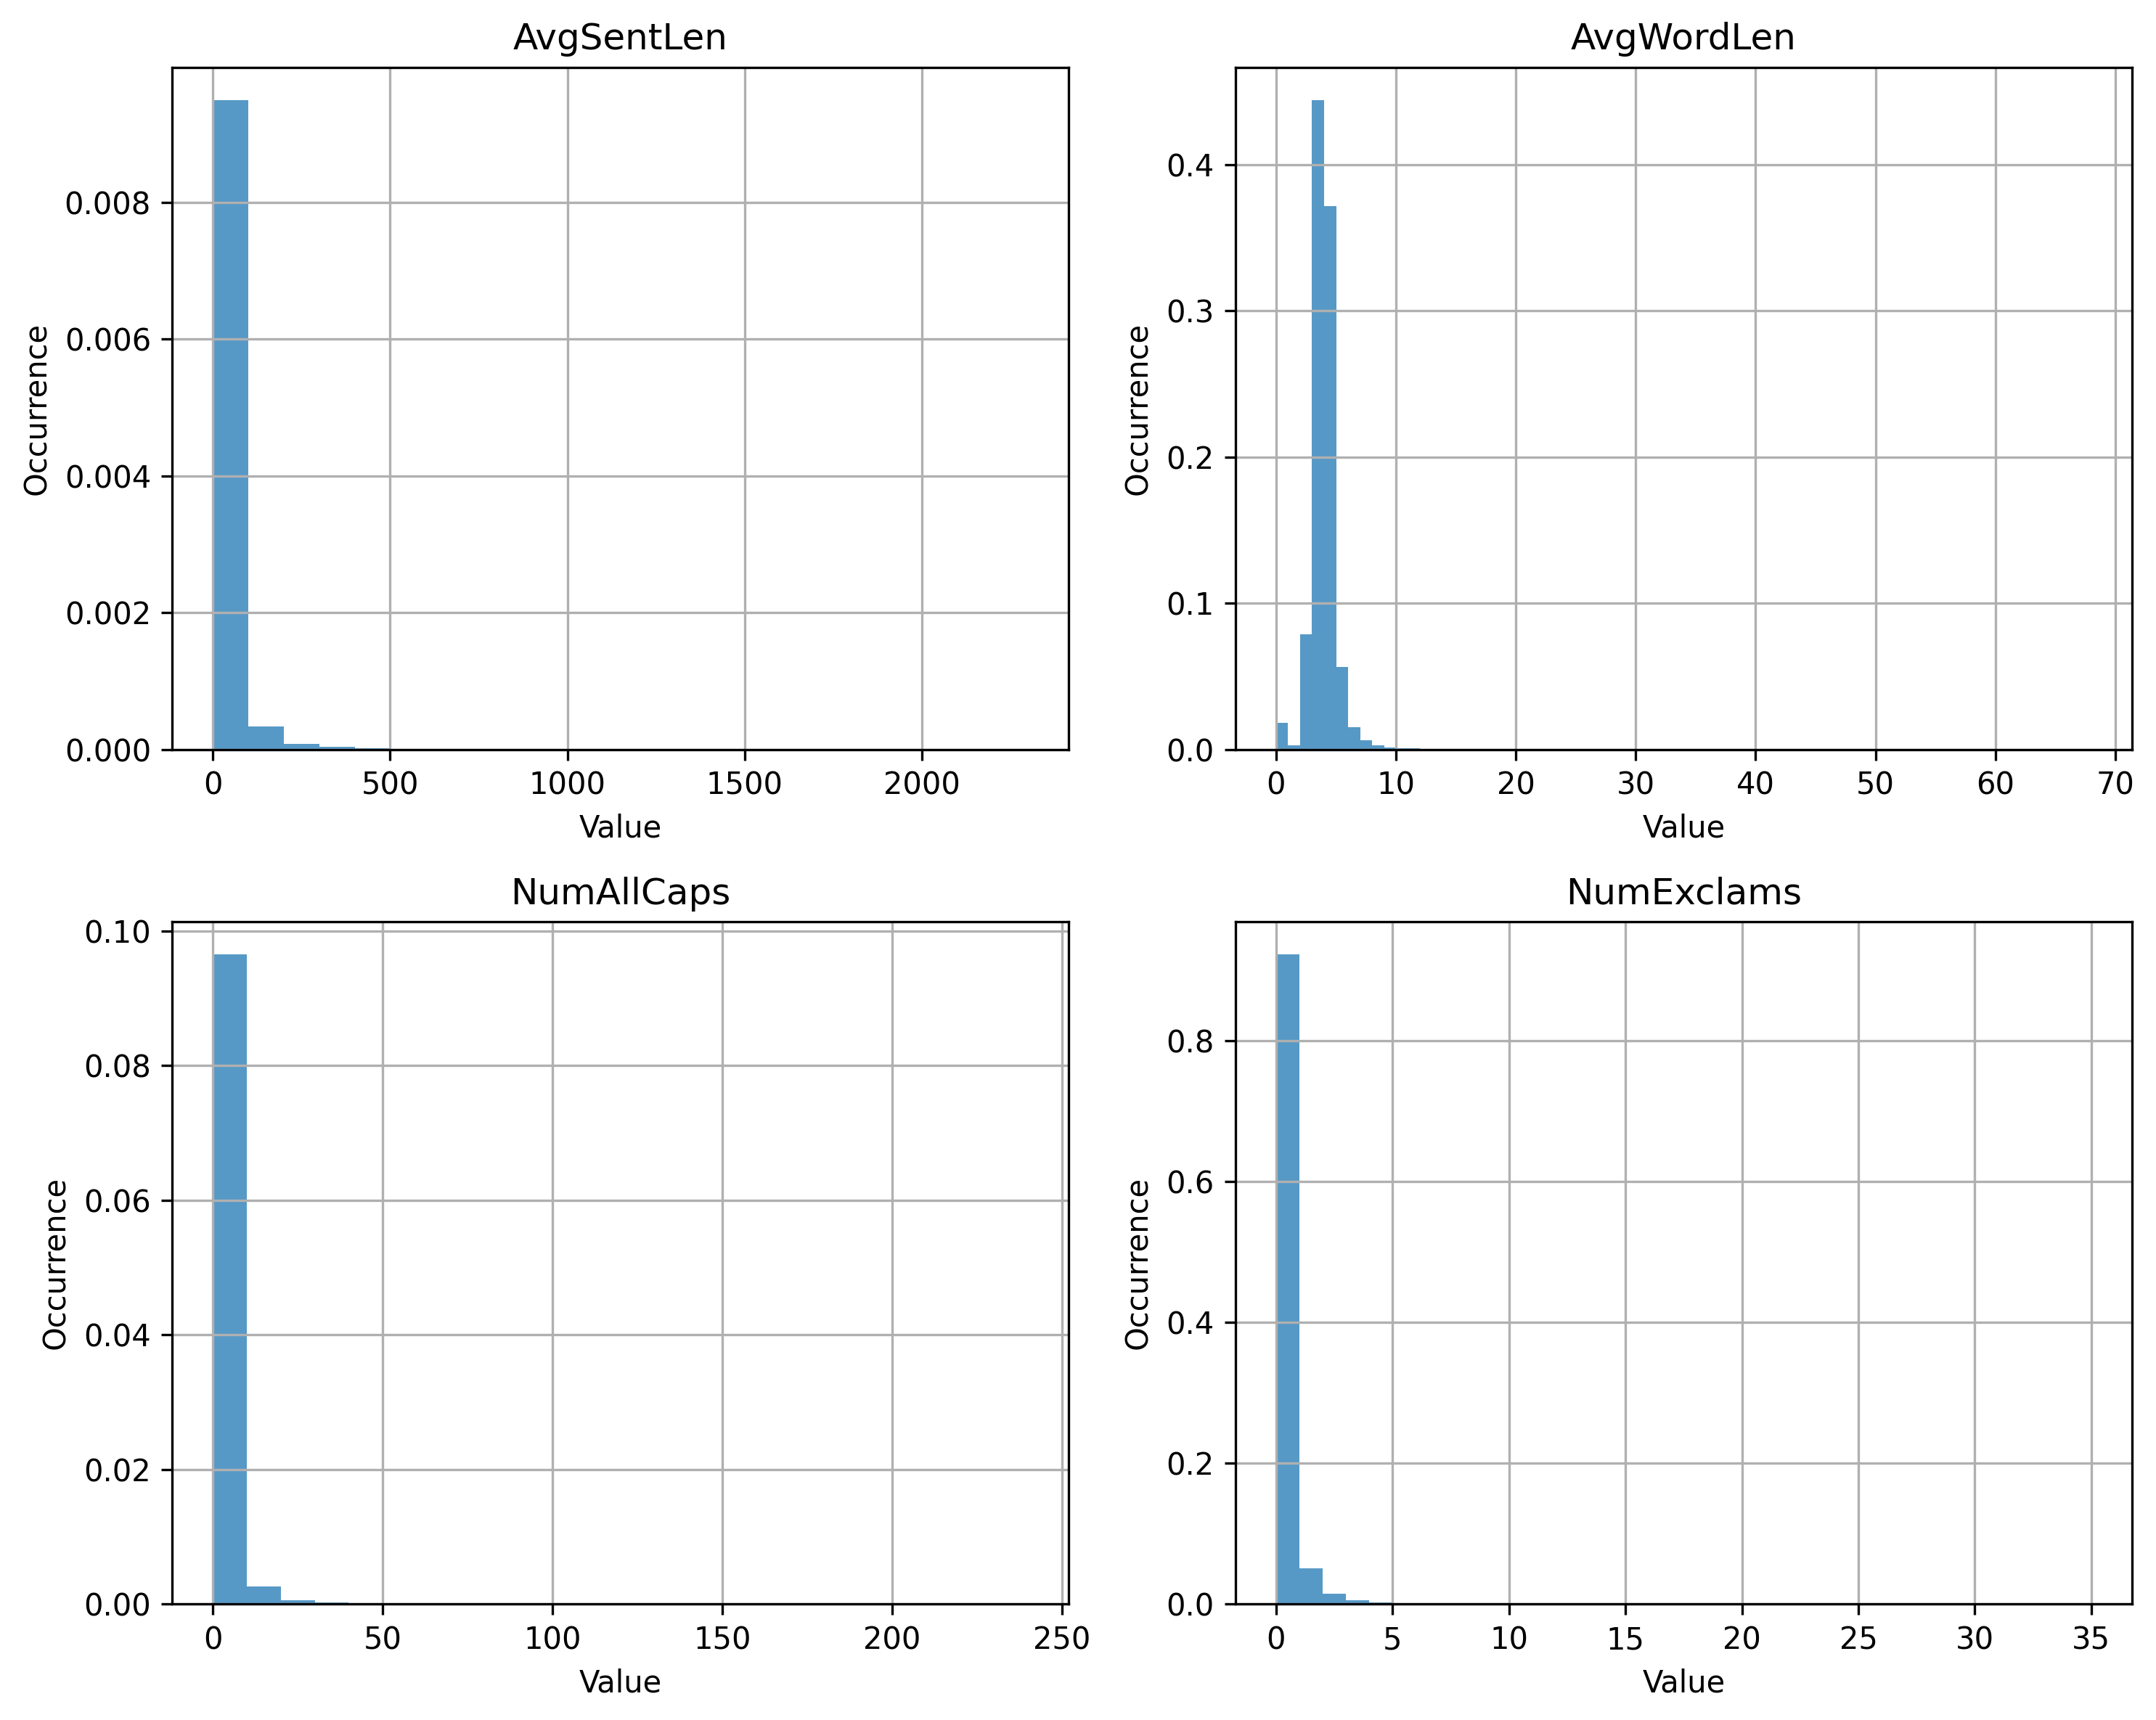

In [13]:
plot_feat_hist([(np.asarray([[meta[aid][feat]] for aid in all_answers], dtype=int), feat) for feat in ['AvgSentLen', 'AvgWordLen', 'NumAllCaps', 'NumExclams']], '03_feat_hist_AvgSentLen_AvgWordLen_NumAllCaps_NumExclams')

With these four additional features, seven features now is obtained representing the individual posts. See how it progresses:

In [14]:
X = np.asarray([get_features(aid, ['LinkCount', 'NumCodeLines', 'NumTextTokens',  'AvgSentLen', 'AvgWordLen', 'NumAllCaps', 'NumExclams']) for aid in all_answers], float)

scores = []
for train, test in cv.split(X, Y):
    clf = make_pipeline(StandardScaler(), KNeighborsClassifier())
    clf.fit(X[train], Y[train])
    scores.append(clf.score(X[test], Y[test]))
print("Mean(scores)={:.5f} \t Stddev(scores)={:.5f}".format(np.mean(scores), np.std(scores)))

Mean(scores)=0.60195 	 Stddev(scores)=0.01071


Now, that's interesting. Four more features were added and didn't get anything in return. How can that be?

To understand this, remind how kNN works. The 5NN classifier determines the class of a new post by calculating the seven aforementioned features—LinkCount, NumTextTokens, NumCodeLines, AvgSentLen, AvgWordLen, NumAllCaps, and NumExclams—and then finds the five nearest other posts. The new post's class is then the majority of the classes of those nearest posts. The nearest posts are determined by calculating the Euclidean distance (as it was not specified, the classifier was initialized with the default p=2, which is the parameter in the Minkowski distance). That means that all seven features are treated similarly.

# High or low bias?

To find out what the problem is, the train and test errors over different data sizes have to be plotted and then check whether the gap between train and test is closing.

High bias is typically revealed by the test error decreasing a bit at the beginning, but then settling at a very high value with the train error approaching with a growing dataset size. High variance is recognized by a big gap between both curves.

Plotting the errors for different dataset sizes for 5NN shows a big gap between train and test errors, hinting at a high variance problem:

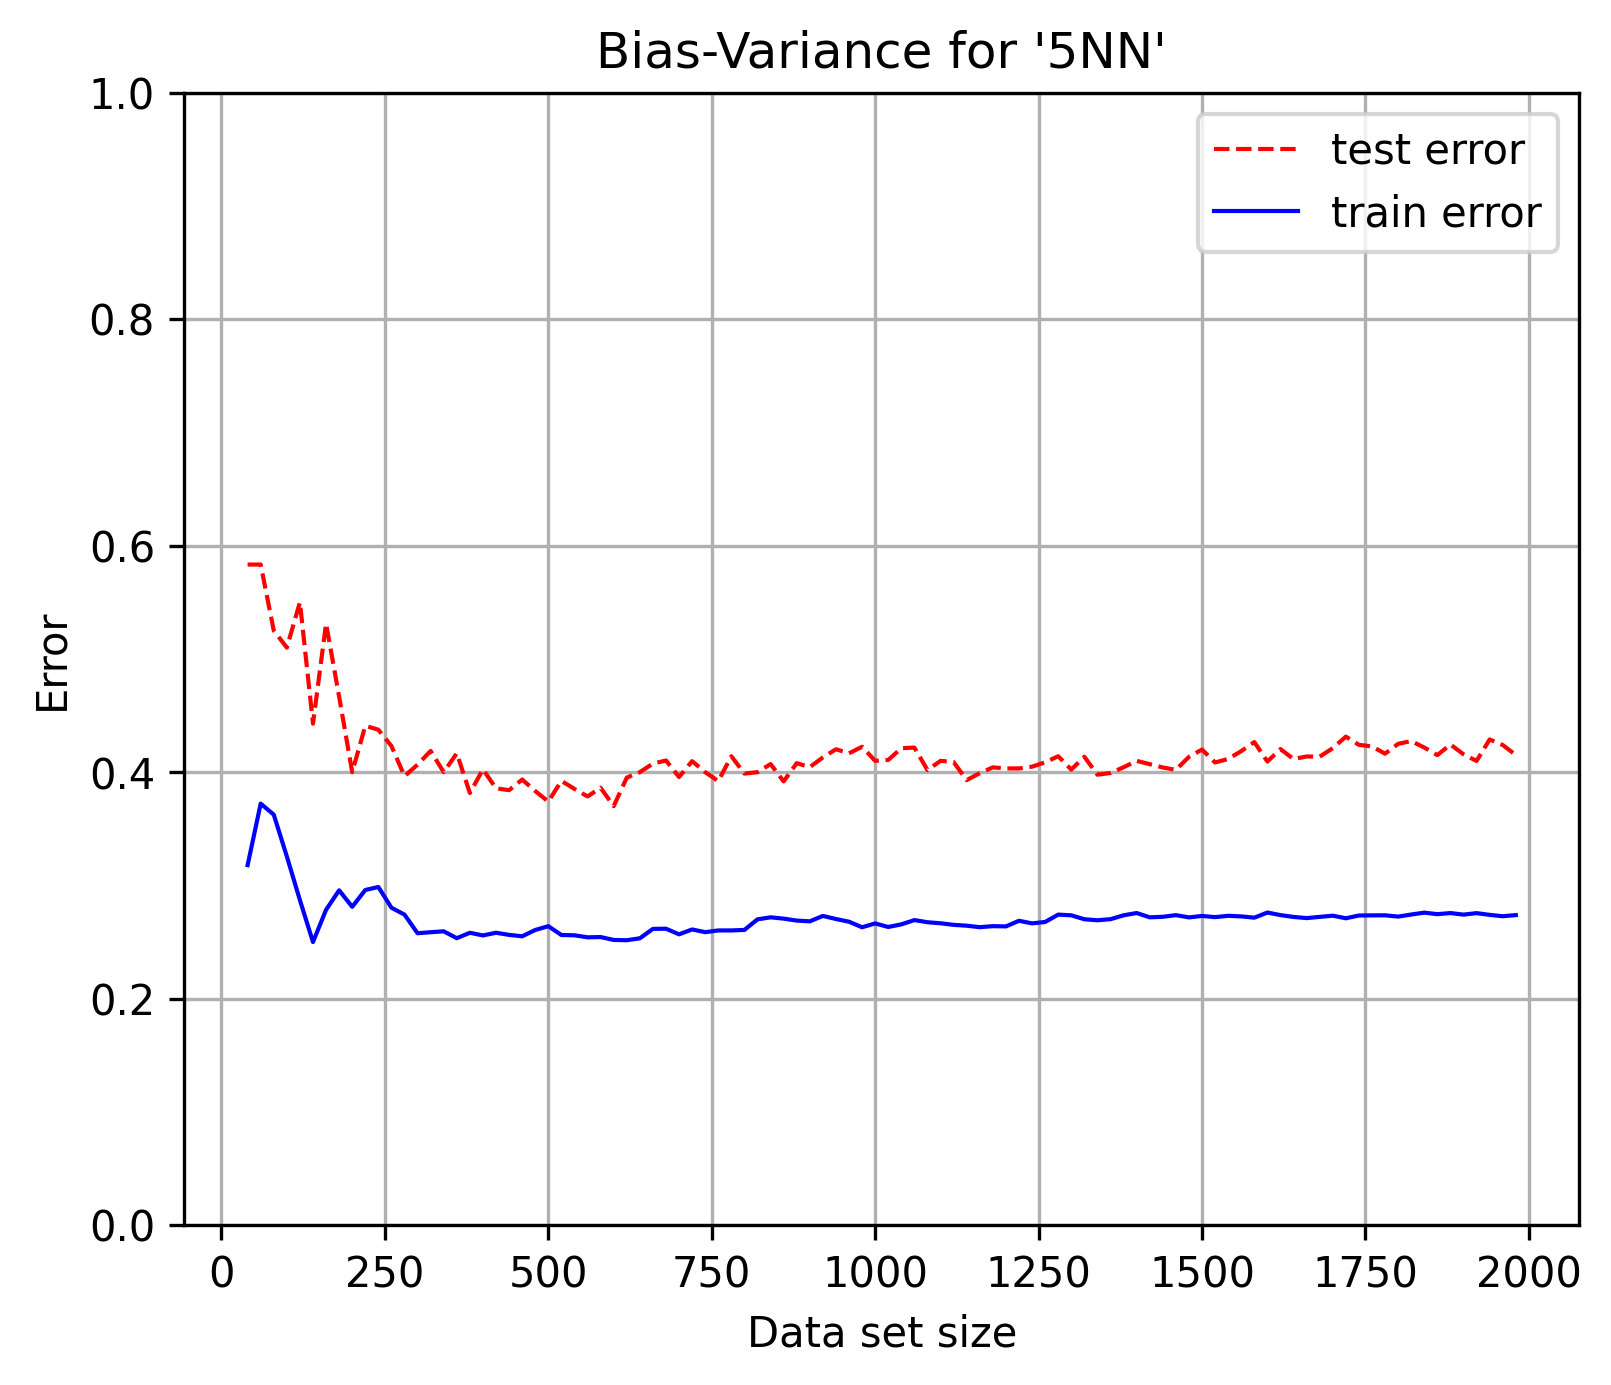

In [15]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc, classification_report

def plot_bias_variance(data_sizes, train_errors, test_errors, title):
    plt.figure(num=None, figsize=(6, 5), dpi=300)
    plt.ylim([0.0, 1.0])
    plt.xlabel('Data set size')
    plt.ylabel('Error')
    plt.title(title)
    plt.plot(data_sizes, test_errors, "r--", data_sizes, train_errors, "b-", lw=1)
    plt.legend(["test error", "train error"], loc="upper right")
    plt.grid(True)
    plt.show()

def plot_pr(auc_score, precision, recall, label=None):
    plt.figure(num=None, figsize=(6, 5), dpi=300)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('P/R (AUC={:0.2f}) / {}'.format(auc_score, label))
    plt.fill_between(recall, precision, alpha=0.5)
    plt.grid(True)
    plt.plot(recall, precision, lw=1)
    plt.show()

def plot_feat_importance(feature_names, clf, name):
    plt.figure(num=None, figsize=(6, 5), dpi=300)
    coef_ = clf.coef_
    important = np.argsort(np.absolute(coef_.ravel()))
    f_imp = feature_names[important]
    coef = coef_.ravel()[important]
    inds = np.argsort(coef)
    f_imp = f_imp[inds]
    coef = coef[inds]
    xpos = np.array(list(range(len(coef))))
    plt.bar(xpos, coef, width=1, alpha=0.75)

    plt.title('Feature importance for {}'.format(name))
    ax = plt.gca()
    ax.set_xticks(np.arange(len(coef)))
    labels = ax.set_xticklabels(f_imp)
    for label in labels:
        label.set_rotation(90)
    plt.show()

def measure(clf_class, parameters, name, X, Y, data_size=None, plot=None, feature_names=None):
    if data_size is not None:
        X = X[:data_size]
        Y = Y[:data_size]

    train_errors = []
    test_errors = []

    scores = []
    roc_scores = []
    fprs, tprs = [], []

    pr_scores = []
    precisions, recalls, thresholds = [], [], []

    for fold_idx, (train, test) in enumerate(cv.split(X, Y)):
        X_train, y_train = X[train], Y[train]
        X_test, y_test = X[test], Y[test]

        only_one_class_in_train = len(set(y_train)) == 1
        only_one_class_in_test = len(set(y_test)) == 1
        if only_one_class_in_train or only_one_class_in_test:
            # this would pose problems later on
            continue

        clf = clf_class(**parameters)

        clf.fit(X_train, y_train)

        train_score = clf.score(X_train, y_train)
        test_score = clf.score(X_test, y_test)

        train_errors.append(1 - train_score)
        test_errors.append(1 - test_score)

        scores.append(test_score)
        proba = clf.predict_proba(X_test)

        label_idx = 1
        fpr, tpr, roc_thresholds = roc_curve(y_test, proba[:, label_idx])
        precision, recall, pr_thresholds = precision_recall_curve(y_test, proba[:, label_idx])

        roc_scores.append(auc(fpr, tpr))
        fprs.append(fpr)
        tprs.append(tpr)

        pr_scores.append(auc(recall, precision))
        precisions.append(precision)
        recalls.append(recall)
        thresholds.append(pr_thresholds)

    # get medium clone
    scores_to_sort = pr_scores  # roc_scores
    medium = np.argsort(scores_to_sort)[len(scores_to_sort) // 2]
    # print("Medium clone is #%i" % medium)

    if plot in ('good', 'poor'):
        #plot_roc(roc_scores[medium], name, fprs[medium], tprs[medium])
        plot_pr(pr_scores[medium], precisions[medium], recalls[medium], plot + " answers")
    elif plot == 'feat_importance':
        if hasattr(clf, 'coef_'):
            plot_feat_importance(feature_names, clf, name)
        elif hasattr(clf, 'named_steps'):
            for step, s_clf in clf.named_steps.items():
                if hasattr(s_clf, 'coef_'):
                    plot_feat_importance(feature_names, s_clf, name)

    summary = {
        'name': name,
        'scores': scores,
        'roc_scores': roc_scores,
        'pr_scores': pr_scores,
        'med_precisions': precisions[medium], 
        'med_recalls': recalls[medium], 
        'med_thresholds': thresholds[medium]
    }
    
    return np.mean(train_errors), np.mean(test_errors), summary

def bias_variance_analysis(clf_class, parameters, name, X, Y):
    data_sizes = np.arange(40, 2000, 20)

    train_errors = []
    test_errors = []

    for data_size in data_sizes:
        train_error, test_error, _ = measure(clf_class, parameters, name, X, Y, data_size=data_size)
        train_errors.append(train_error)
        test_errors.append(test_error)

    plot_bias_variance(data_sizes, train_errors, test_errors, "Bias-Variance for '{}'".format(name))

def create_pipeline(**param):
    return make_pipeline(StandardScaler(), KNeighborsClassifier(**param))

bias_variance_analysis(create_pipeline, {'n_neighbors': 5}, "5NN", X, Y)

As the test error does not decrease with more data, it is necessery to rethink the model. The model complexity certainly can be decreased, either by increasing k or by simplifying the feature space.

Reducing the feature space does not help here, as shown by the following graph, for a simplified feature space of only LinkCount and NumTextTokens:

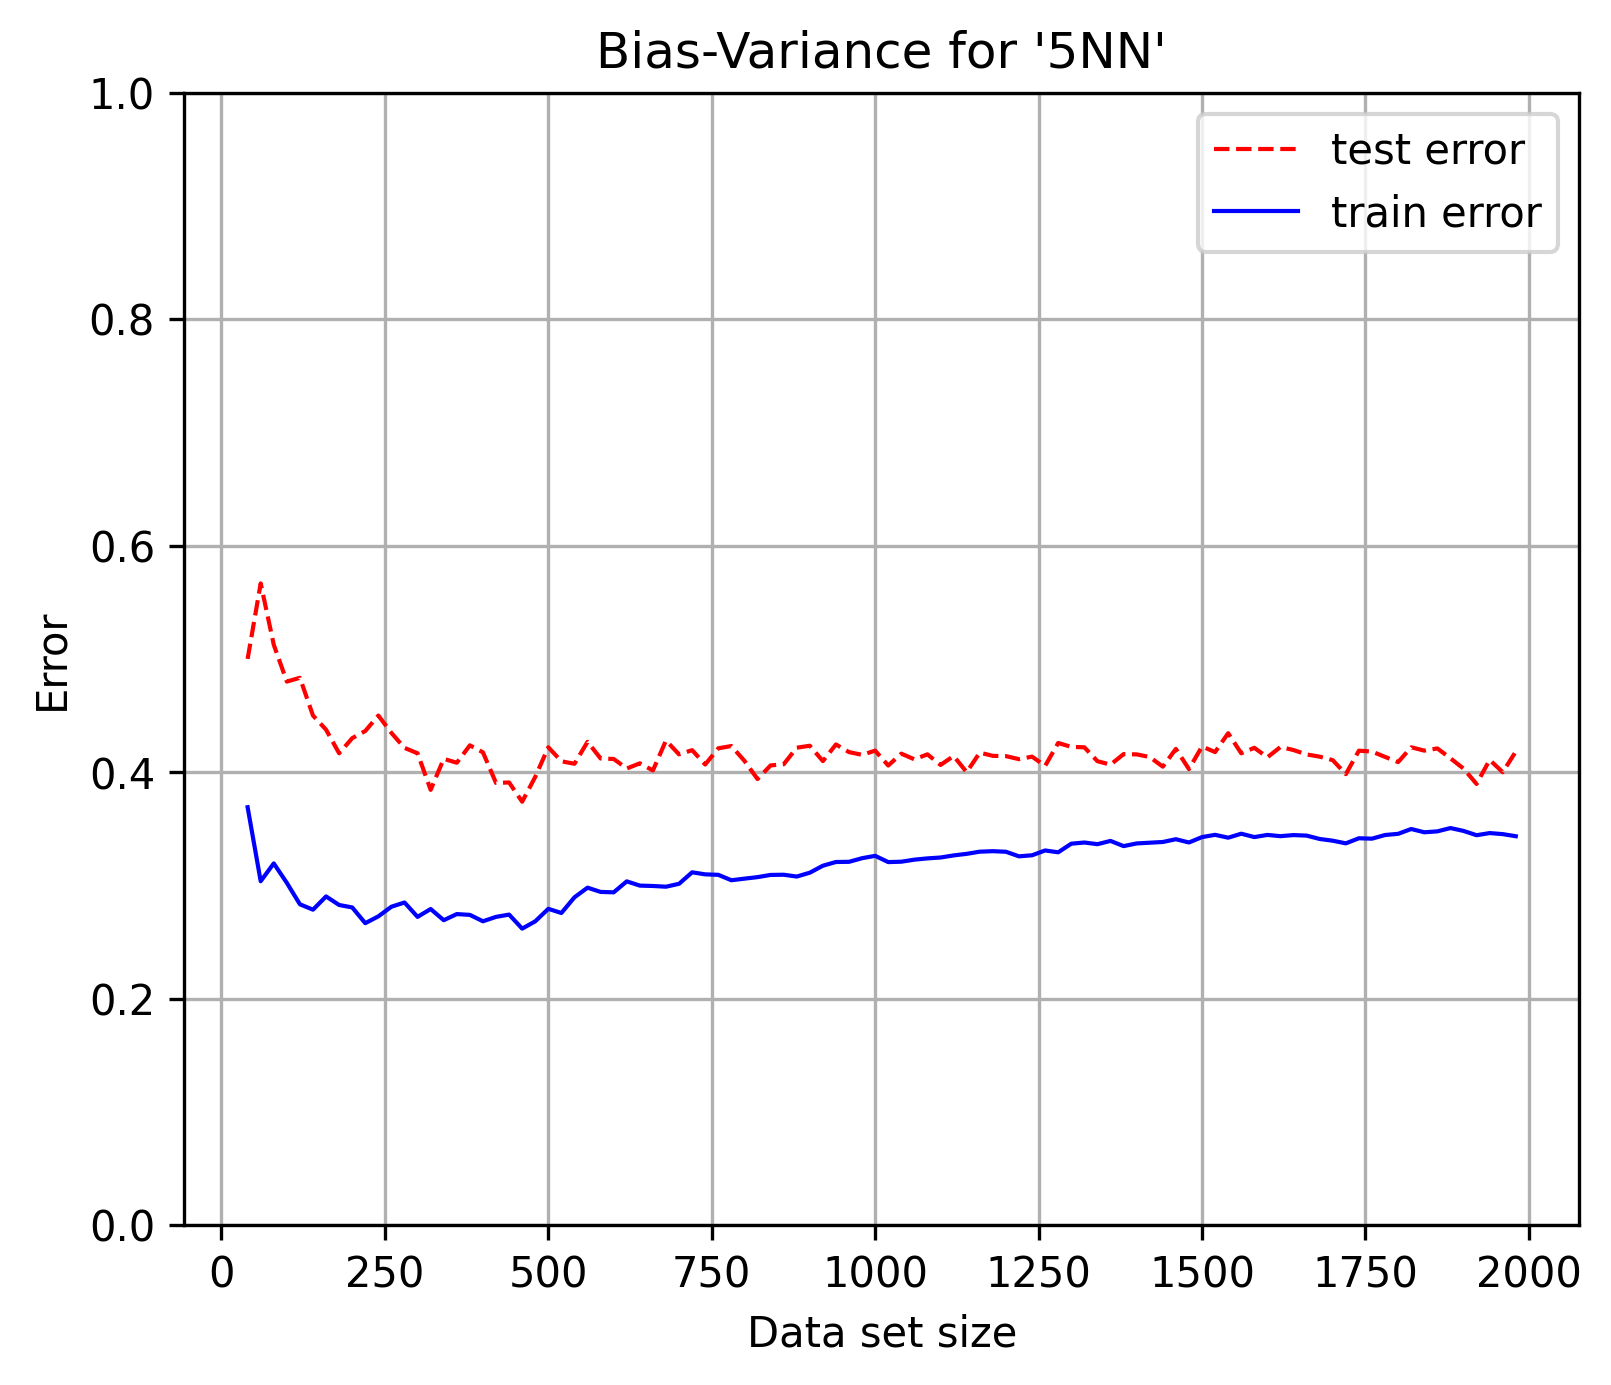

In [16]:
from sklearn.utils import shuffle

X_simp = np.asarray([get_features(aid, ['LinkCount', 'NumTextTokens']) for aid in all_answers], float)
X_simp, Y_simp = shuffle(X_simp, Y, random_state=0)

bias_variance_analysis(create_pipeline, {'n_neighbors': 5}, "5NN", X_simp, Y_simp)

Similar graphs are shown for other smaller feature sets. No matter what subset of features it takes, the graph would look similar.

Another way to reduce the model complexity is to increase k, which results into a smoother decision boundary. Trained again on all features, a positive impact is seen:

In [17]:
print('k \t mean(scores) \t stddev(scores)')
for k in [5, 10, 40]:
    _, _, summary = measure(create_pipeline, {'n_neighbors': k}, "{}NN".format(k), X, Y)
    print('{} \t {:.4f} \t\t {:.4f}'.format(k, np.mean(summary['scores']), np.std(summary['scores'])))

k 	 mean(scores) 	 stddev(scores)
5 	 0.6020 		 0.0107
10 	 0.6146 		 0.0065
40 	 0.6382 		 0.0088


But it is not enough, and also comes at the price of lower classification-runtime performance. Take, for instance, k=40, which has the highest average precision in the preceding table. To classify a new post, it would need to find the 40 nearest other posts to decide whether the new post is a good one or not.

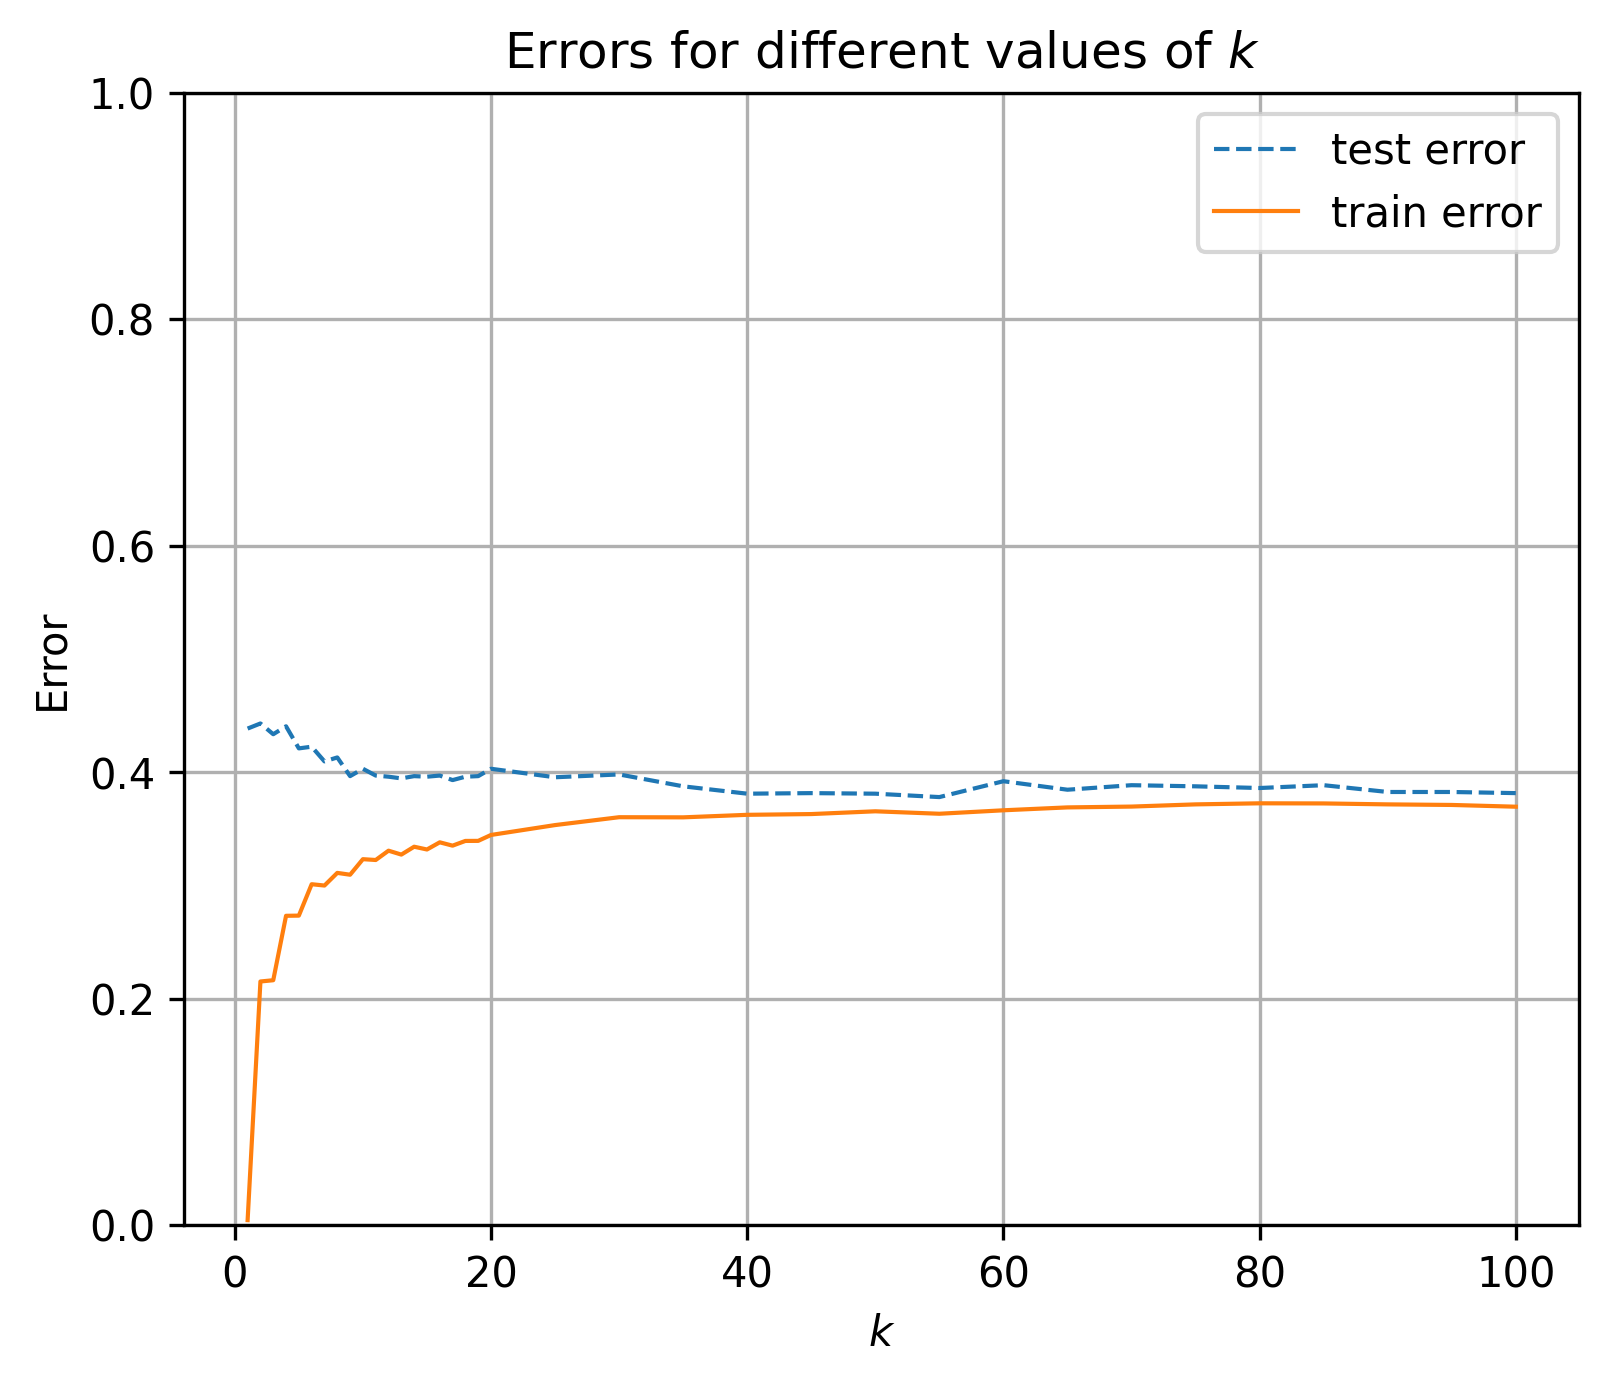

In [18]:
def plot_k_complexity(ks, train_errors, test_errors):
    plt.figure(num=None, figsize=(6, 5), dpi=300)
    plt.ylim([0.0, 1.0])
    plt.xlabel('$k$')
    plt.ylabel('Error')
    plt.title('Errors for different values of $k$')
    plt.plot(ks, test_errors, "--", ks, train_errors, "-", lw=1)
    plt.legend(["test error", "train error"], loc="upper right")
    plt.grid(True)
    plt.show()

def k_complexity_analysis(clf_class, X, Y):
    # Measure for different k's: [1,2,..,20,25,..,100]
    ks = np.hstack((np.arange(1, 21), np.arange(25, 101, 5)))
    
    train_errors = []
    test_errors = []

    for k in ks:
        train_error, test_error, _ = measure(clf_class, {'n_neighbors': k}, "{}NN".format(k), X, Y, data_size=2000)
        train_errors.append(train_error)
        test_errors.append(test_error)

    plot_k_complexity(ks, train_errors, test_errors)


k_complexity_analysis(create_pipeline, X, Y)

Clearly, there seems to be an issue with using nearest-neighbor for our scenario. And it has another real disadvantage. Over time, more and more posts will be stored into the system. As the nearest-neighbor method is an instance-based approach, all posts will have to be stored in the system. This is different with model-based approaches, where one tries to derive a model from the data.

There it is, with enough reasons now to abandon the nearest-neighbor approach to look for better places in the classification world. Move on to another classification method that is known to work great in text-based classification scenarios.

## Using logistic regression

Contrary to its name, logistic regression is a classification method. It is an enormously powerful one when it comes to text-based classification; it achieves this by first doing a regression on a logistic function, hence the name.

## A bit of math with a small example

To get an initial understanding of the way logistic regression works, first take a look at the following example, where there are artificial feature values, X, plotted with the corresponding classes, 0 or 1:

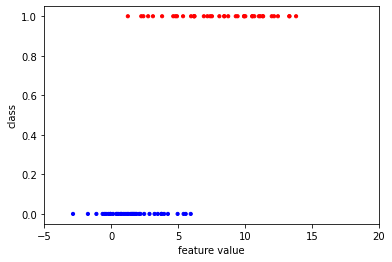

In [19]:
from scipy.stats import norm

np.random.seed(3) # for reproducibility
NUM_PER_CLASS = 40
X_log = np.hstack((norm.rvs(2, size=NUM_PER_CLASS, scale=2),
norm.rvs(8, size=NUM_PER_CLASS, scale=3)))
y_log = np.hstack((np.zeros(NUM_PER_CLASS),
np.ones(NUM_PER_CLASS))).astype(int)
plt.xlim((-5, 20))
plt.scatter(X_log, y_log, c=np.array(['blue', 'red'])[y_log], s=10)
plt.xlabel("feature value")
plt.ylabel("class")
plt.show()

As it can be seen, the data so noisy that classes overlap in the feature value range between 1 and 6. Therefore, it is better to not directly model the discrete classes, but rather the probability that a feature value belongs to class 1, P(X). Once a model is resulted, it could then predict class 1 if P(X)>0.5, and class 0 otherwise.

Mathematically, it is always difficult to model something that has a finite range, as is the case here with the discrete labels, 0 and 1. The probabilities therefore are tweaked a bit so that they always stay between 0 and 1. And for that, the odds ratio and the logarithm of it will be needed.

Let's say a feature has a probability of 0.9 that it belongs to class 1, P(y=1) = 0.9. The odds ratio is then P(y=1)/P(y=0) = 0.9/0.1 = 9. So that the chance is 9:1 that this feature maps to class 1. The odds ratio is bounded by 0 but goes to infinity (the left graph in the following set of graphs). Take the logarithm of it, all probabilities between 0 and 1 can be mapped to the full range from negative to positive-infinity (the right graph in the following set of graphs). The nice thing is that the relationship is still maintained that higher probability leads to a higher log of odds, just not limited to 0 and 1 anymore:

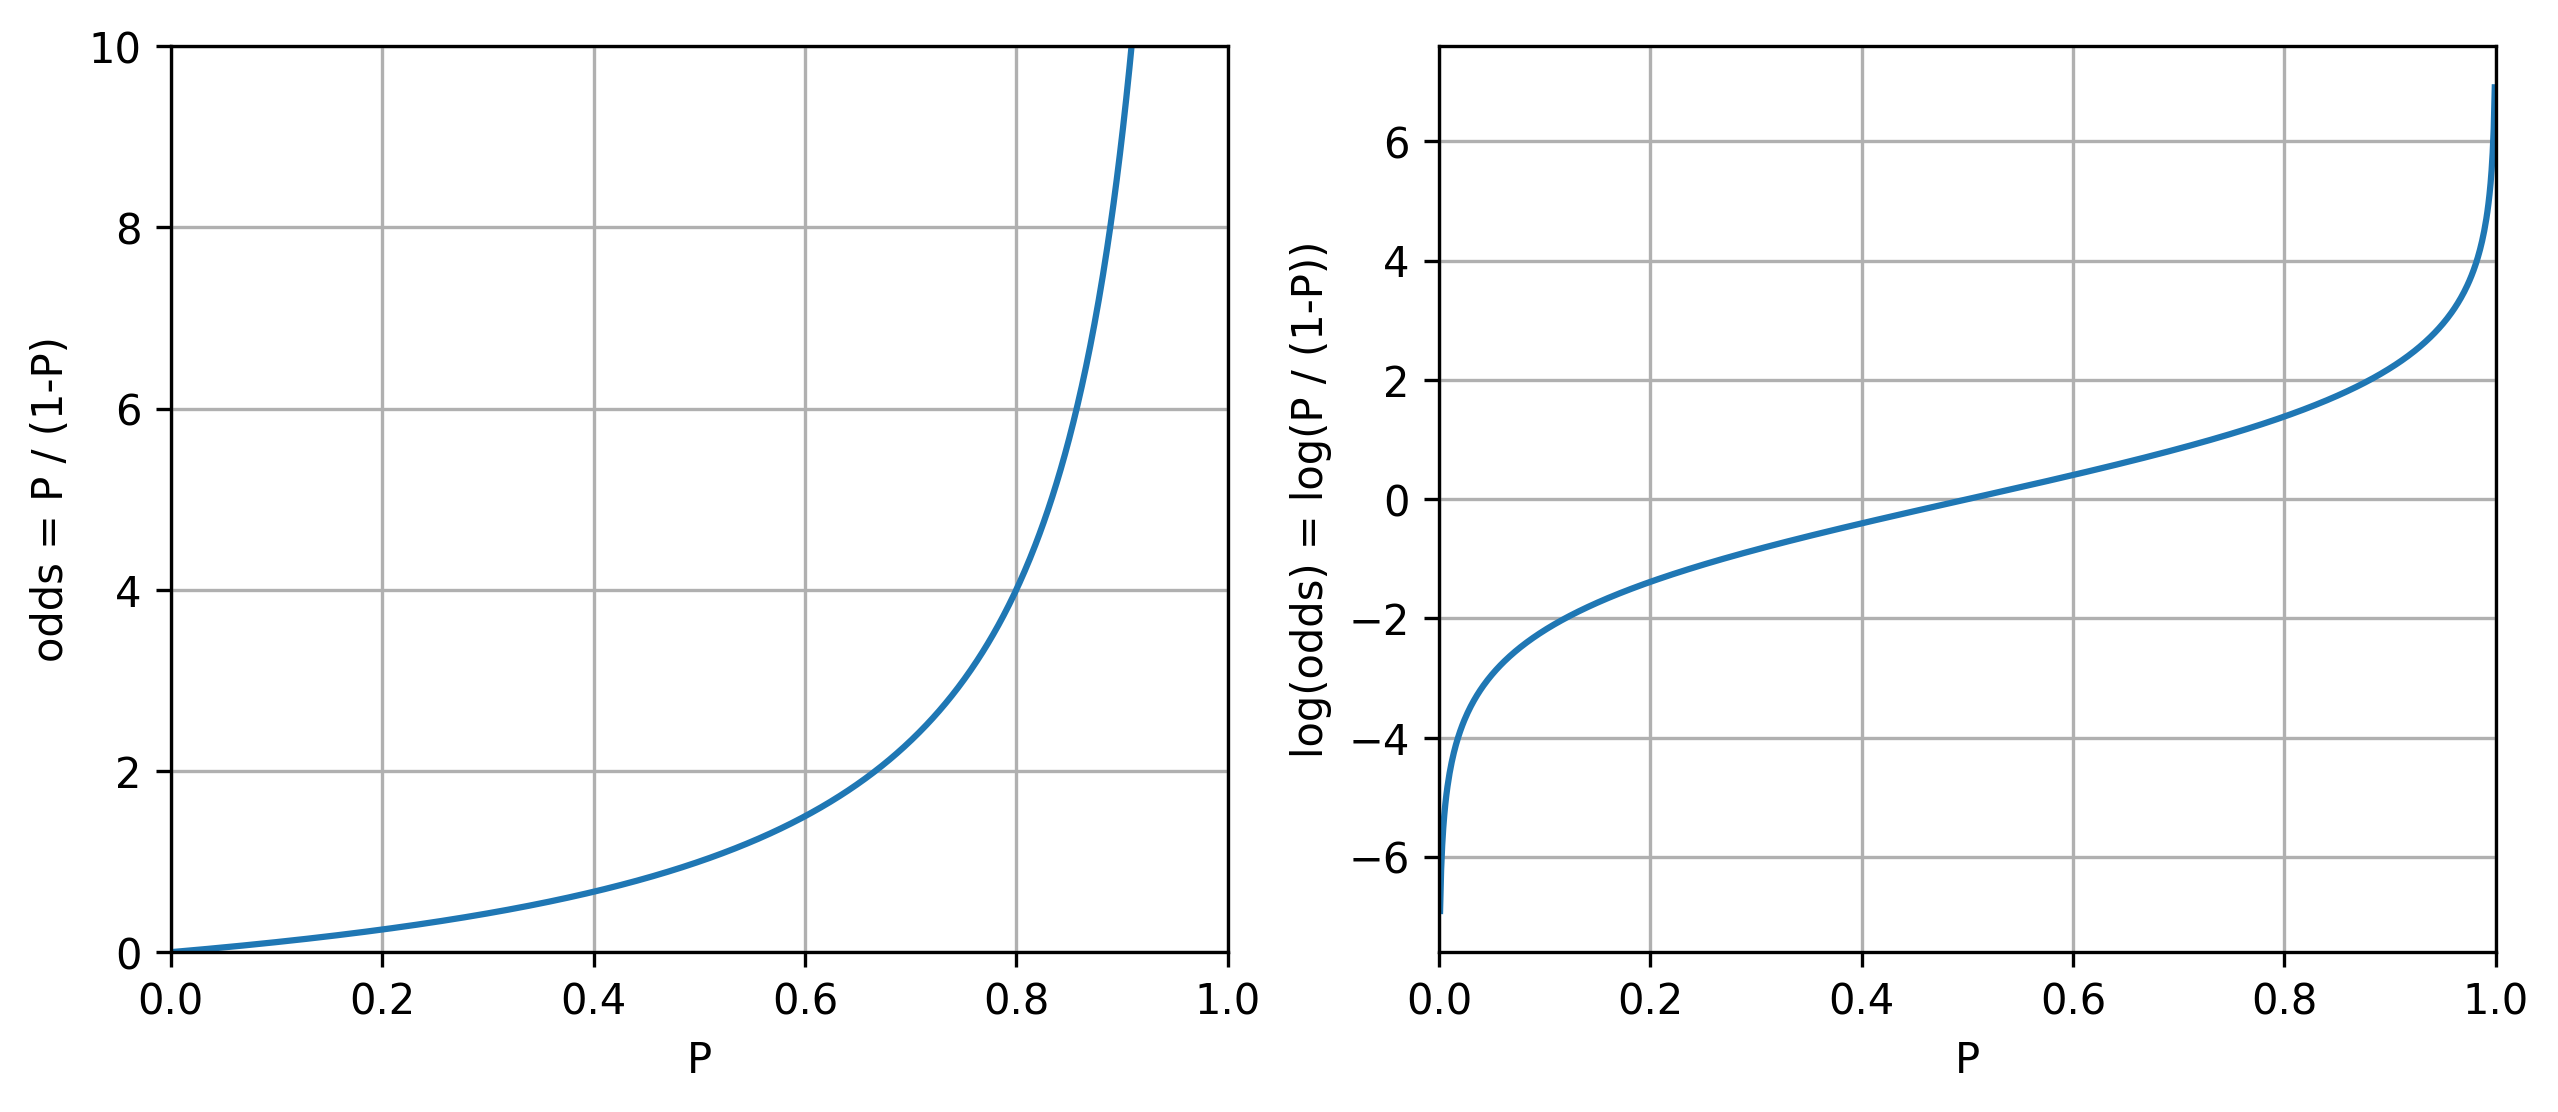

In [20]:
X_odds = np.arange(0.001, 1, 0.001)
plt.figure(figsize=(10, 4), dpi=300)
plt.subplot(1, 2, 1)
plt.xlim((0, 1))
plt.ylim((0, 10))
plt.plot(X_odds, X_odds / (1 - X_odds))
plt.xlabel("P")
plt.ylabel("odds = P / (1-P)")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.xlim((0, 1))
plt.plot(X_odds, np.log(X_odds / (1 - X_odds)))
plt.xlabel("P")
plt.ylabel("log(odds) = log(P / (1-P))")
plt.grid(True)
plt.show()

This means that linear combinations of the features can be now fitted (OK, there is only one and a constant, but that will change soon) to the log(odds) values. In a sense, we replace the linear from [Chapter 1](https://github.com/robitalhazmi/machine_learning/blob/main/Chapter01/chapter_01.ipynb) with this equation (replacing y with log(odds)).
# ![Posts](./Logistic%20Regression.PNG)

This can be solved for Pi, so that
# ![Posts](./Pi.PNG)

the right coefficients simply have to be found, such that the formula gives the lowest errors for all the (xi, pi) pairs in the dataset, but that will be done by scikit-learn.

After fitting, the formula will give the probability for every new data point, x, that belongs to class 1:

In [21]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
print(clf)

clf.fit(X_log.reshape(-1, 1), y_log)
print(np.exp(clf.intercept_), np.exp(clf.coef_.ravel()))

def lr_model(clf, X):
    return 1 / (1 + np.exp(-(clf.intercept_ + clf.coef_ * X)))

print("P(x=-1)={:.2f} \t P(x=7)={:.2f}".format(lr_model(clf, -1).flatten()[0], lr_model(clf, 7).flatten()[0]))

LogisticRegression()
[0.03518544] [2.17570283]
P(x=-1)=0.02 	 P(x=7)=0.89


Notice that scikit-learn exposes the first coefficient through the intercept_special field.

If the fitted model is plotted, it is shown that it makes perfect sense given the data:

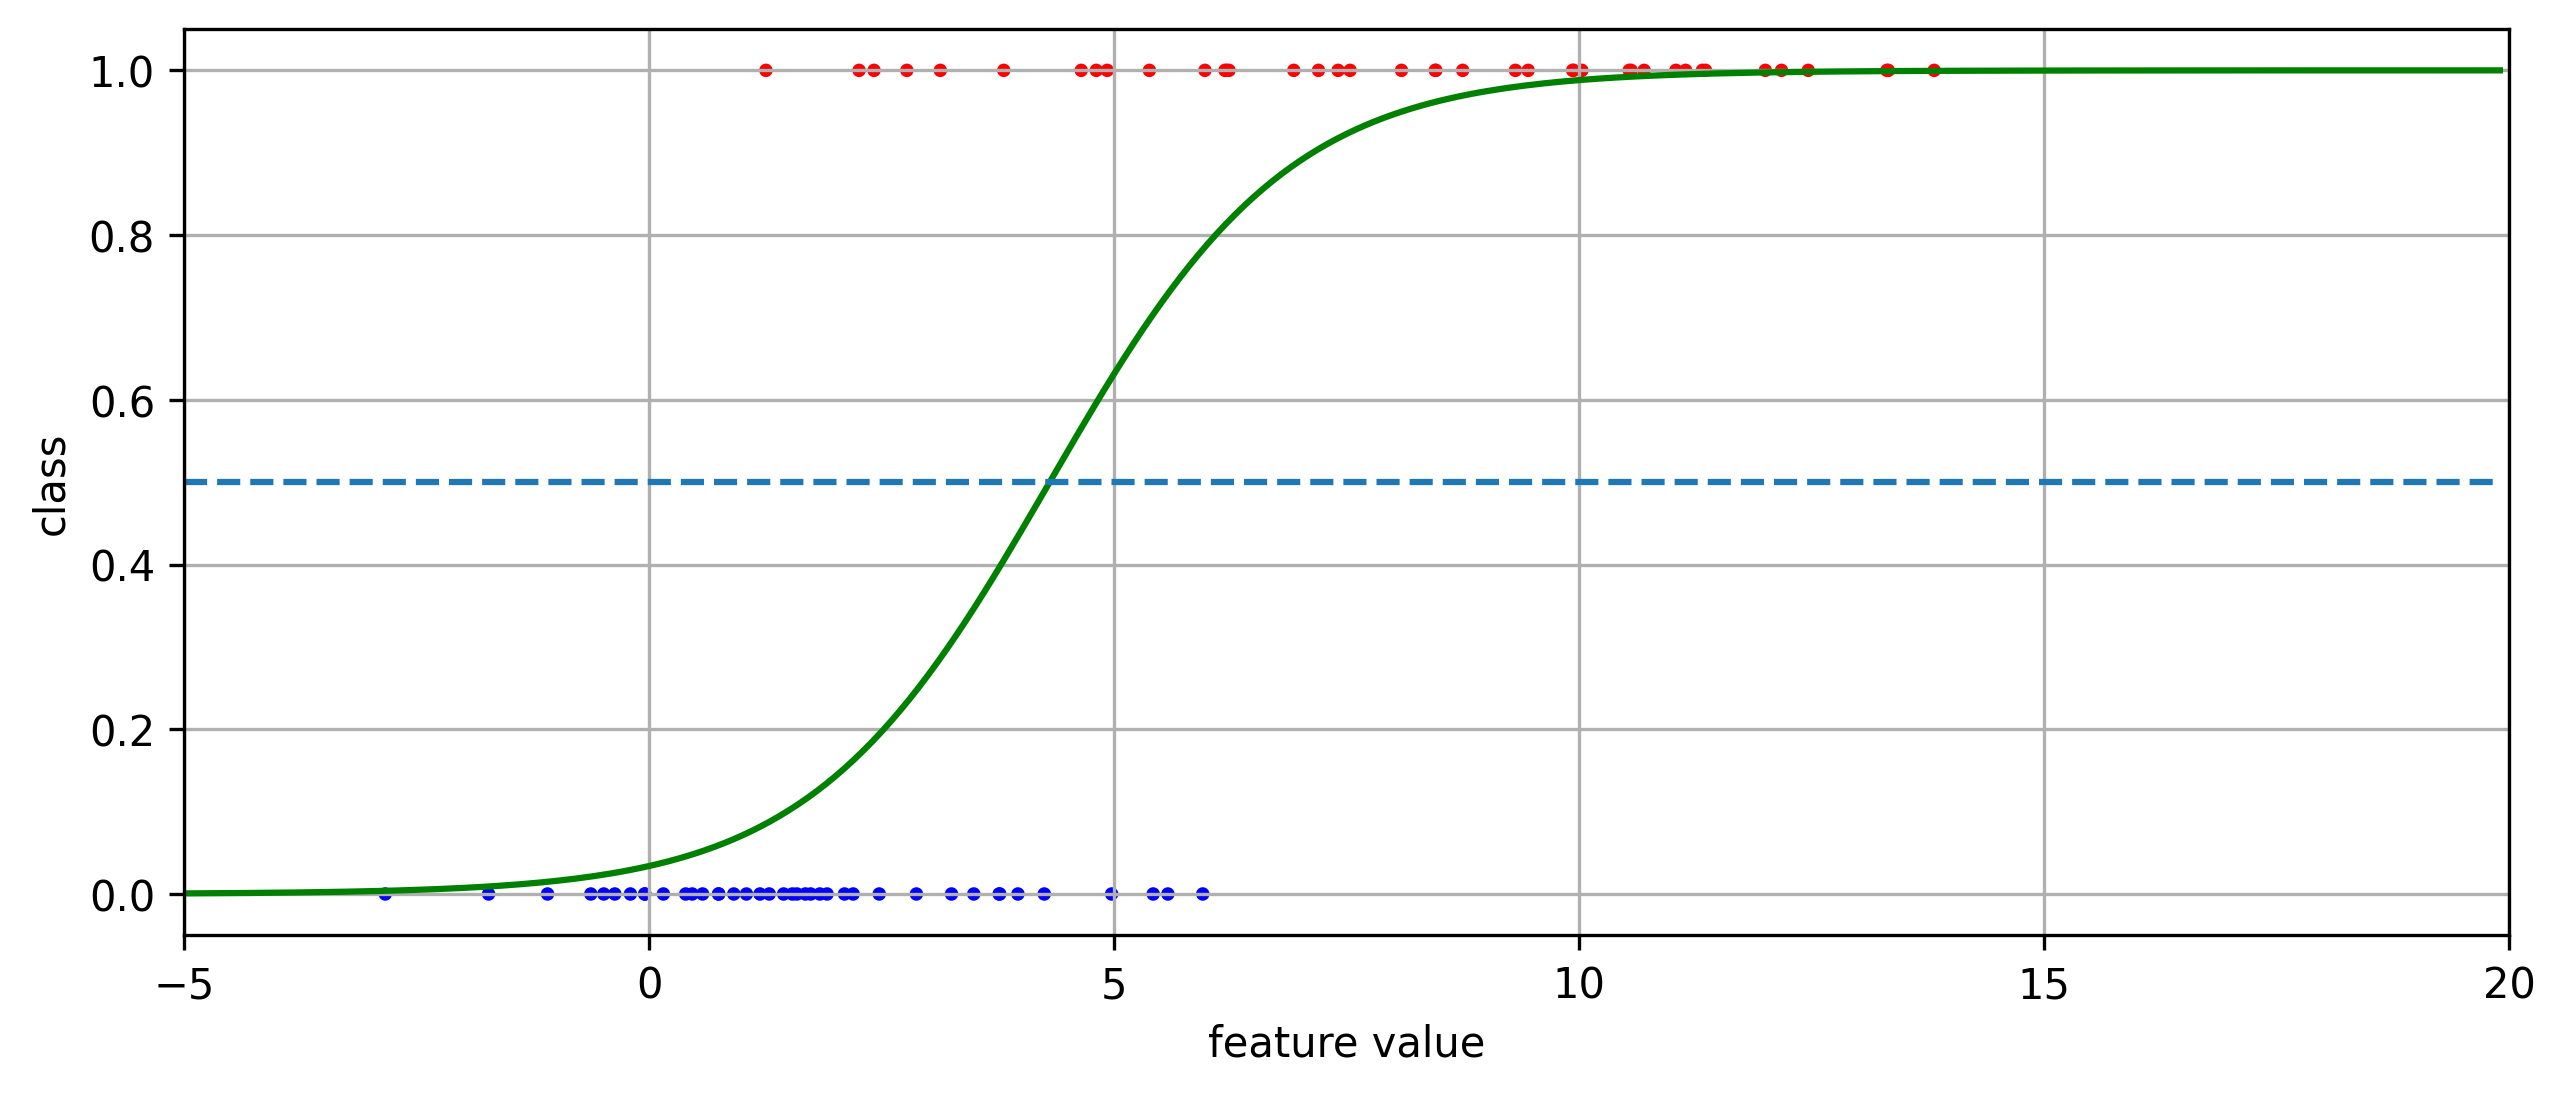

In [22]:
X_range = np.arange(-5, 20, 0.1)
plt.figure(figsize=(10, 4), dpi=300)
plt.xlim((-5, 20))
plt.scatter(X_log, y_log, c=np.array(['blue', 'red'])[y_log], s=5)
# use ravel() to get rid of the additional axis
plt.plot(X_range, lr_model(clf, X_range).ravel(), c='green')
plt.plot(X_range, np.ones(X_range.shape[0]) * 0.5, "--")
plt.xlabel("feature value")
plt.ylabel("class")
plt.grid(True)
plt.show()

## Applying logistic regression to the post-classification problem

Admittedly, the example in the previous section was created to show the beauty of logistic regression. How does it perform on the real noisy data?

Comparing it to the best nearest-neighbor classifier (k=40) as a baseline, it shows that it won't change the situation a whole lot:

In [23]:
print('C \t mean(scores) \t stddev(scores)')
for C in [0.001, 0.01, 0.1, 1.0, 10.0]:
    name = "LogReg C={:.2f}".format(C)
    _, _, summary = measure(LogisticRegression, {'C': C, 'max_iter': 200}, name, X, Y)
    print('{:.3f} \t {:.4f} \t\t {:.4f}'.format(C, np.mean(summary['scores']), np.std(summary['scores'])))

C 	 mean(scores) 	 stddev(scores)
0.001 	 0.6337 		 0.0100
0.010 	 0.6337 		 0.0101
0.100 	 0.6336 		 0.0104
1.000 	 0.6338 		 0.0103
10.000 	 0.6337 		 0.0104


The accuracy has been shown for different values of the C regularization parameter. Smaller values for C result in more penalization of the model complexity.

A quick look at the bias-variance chart for one of the best candidates, C=1.0, shows that the model has high bias-test and train-error curves, approach closely but stay at unacceptably high values. This indicates that logistic regression with the current feature space is under-fitting and cannot learn a model that captures the data correctly:

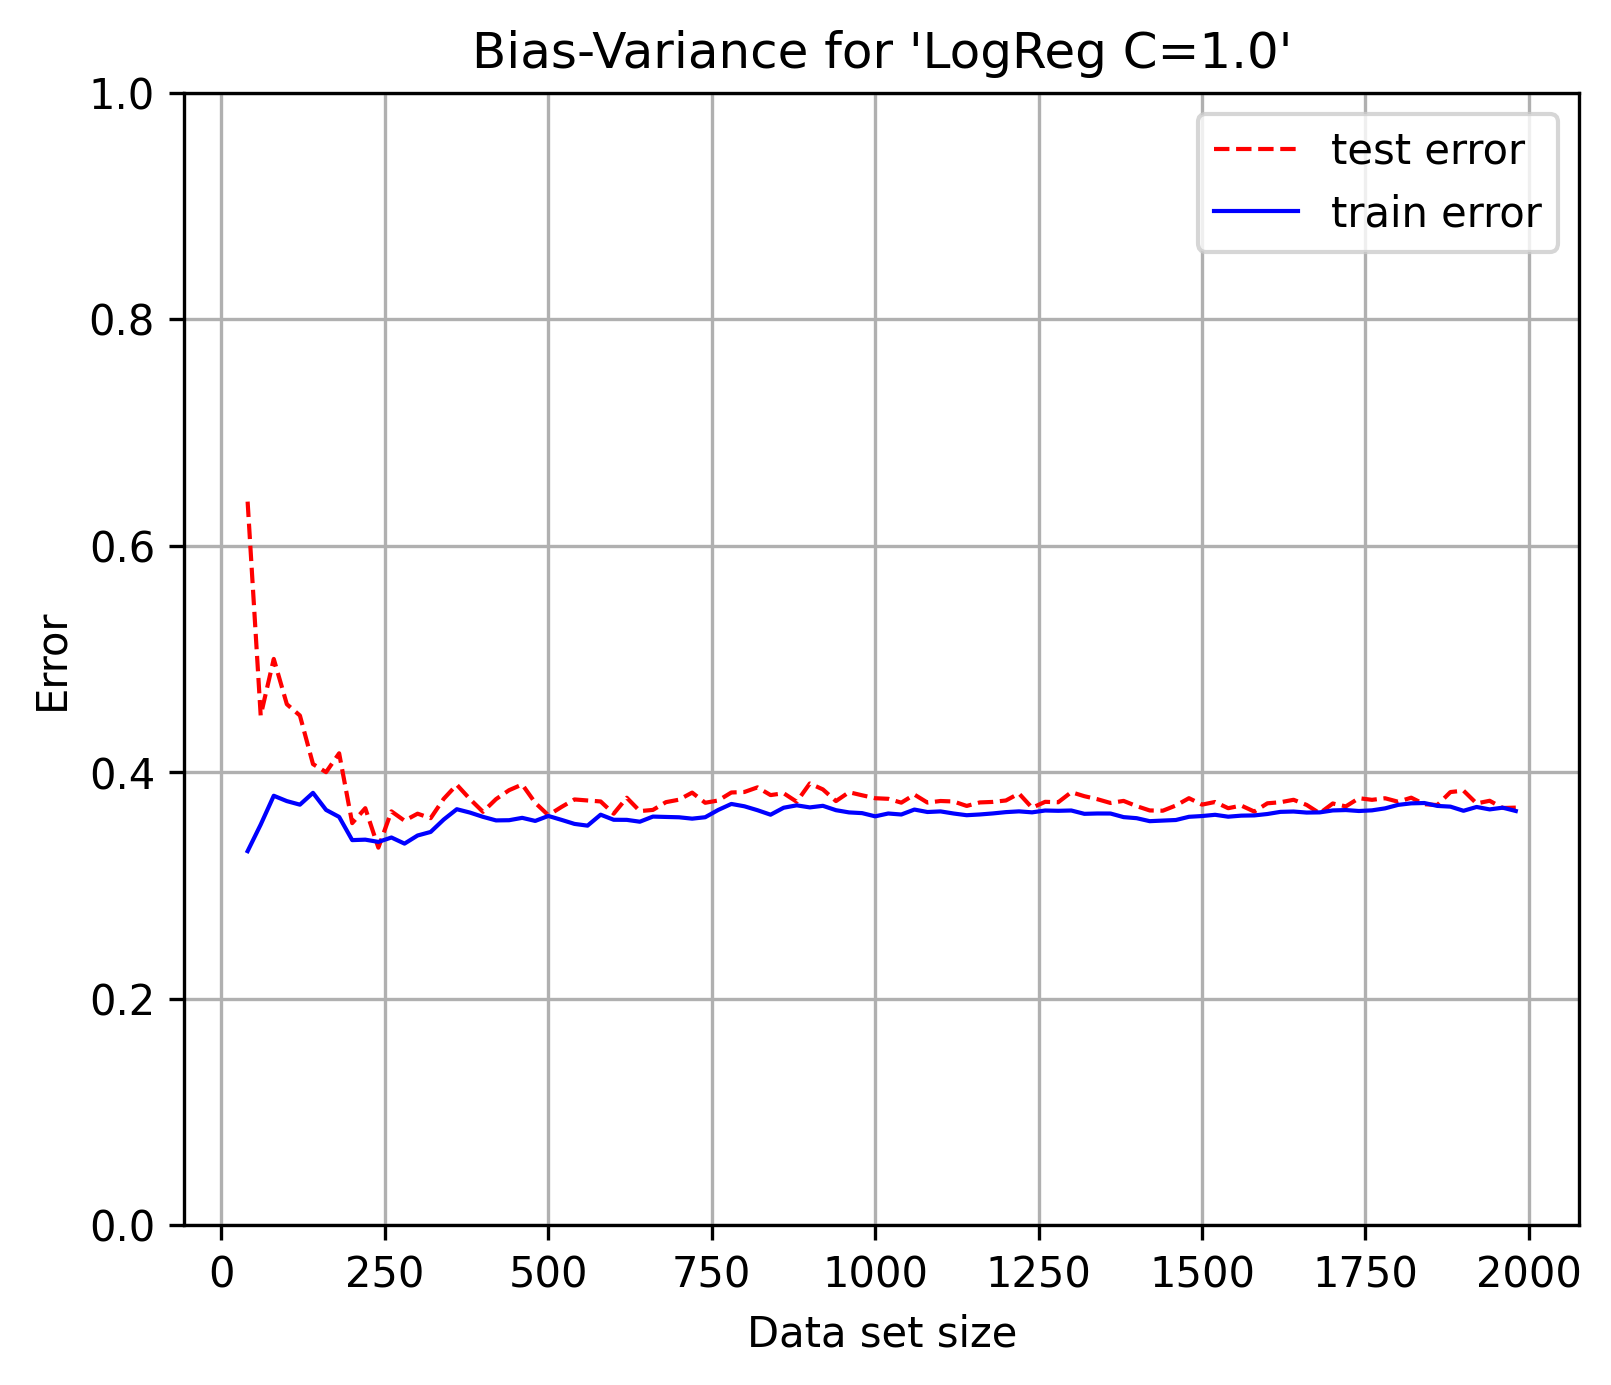

In [24]:
C_best = 1.0
bias_variance_analysis(LogisticRegression, {'C': C_best, 'max_iter': 200}, "LogReg C=1.0", X, Y)

So, what now? The only result by switching is that now it results a model that scales with the data, since it doesn't need to store all the instances.

More and more, it seems that either the data is too noisy for this task or that our set of features is still not appropriate enough to discriminate the classes properly.

# Looking behind accuracy – precision and recall

Step back and think again about the objectives. Actually, a classifier that perfectly predicts good and bad answers is not needed, as it was measured until now using accuracy. If there, for example, was a classifier that always
right when it predicted an answer to be bad, no feedback would be given until the classifier detected the answer to be bad. On the contrary, if the classifier exceeded in predicting answers to be good, we could show helpful comments to the user at the beginning and remove them when the classifier said that the answer is a good one.

To find out which situation it is in, it neceserry to understand how to measure precision and recall. And to understand that, look into the four distinct classification results as they are described in the following table:

# ![Posts](./Precision%20and%20recall.PNG)

For instance, if the classifier predicts an instance to be positive and the instance is indeed positive, this is a true positive instance. If, on the other hand, the classifier misclassified that instance, saying that it is negative while in reality it was positive, that instance is said to be a false negative.

The goal is to have a high success rate when a post is being predicted as either good or bad, but not necessarily both.  This is what precision capture:

# ![Posts](./Precision.PNG)

If, instead, the goal have been to detect as many good or bad answers as possible, it would be more interested in recall:

# ![Posts](./Recall.PNG)

Refer to the following graph:

Good answers...


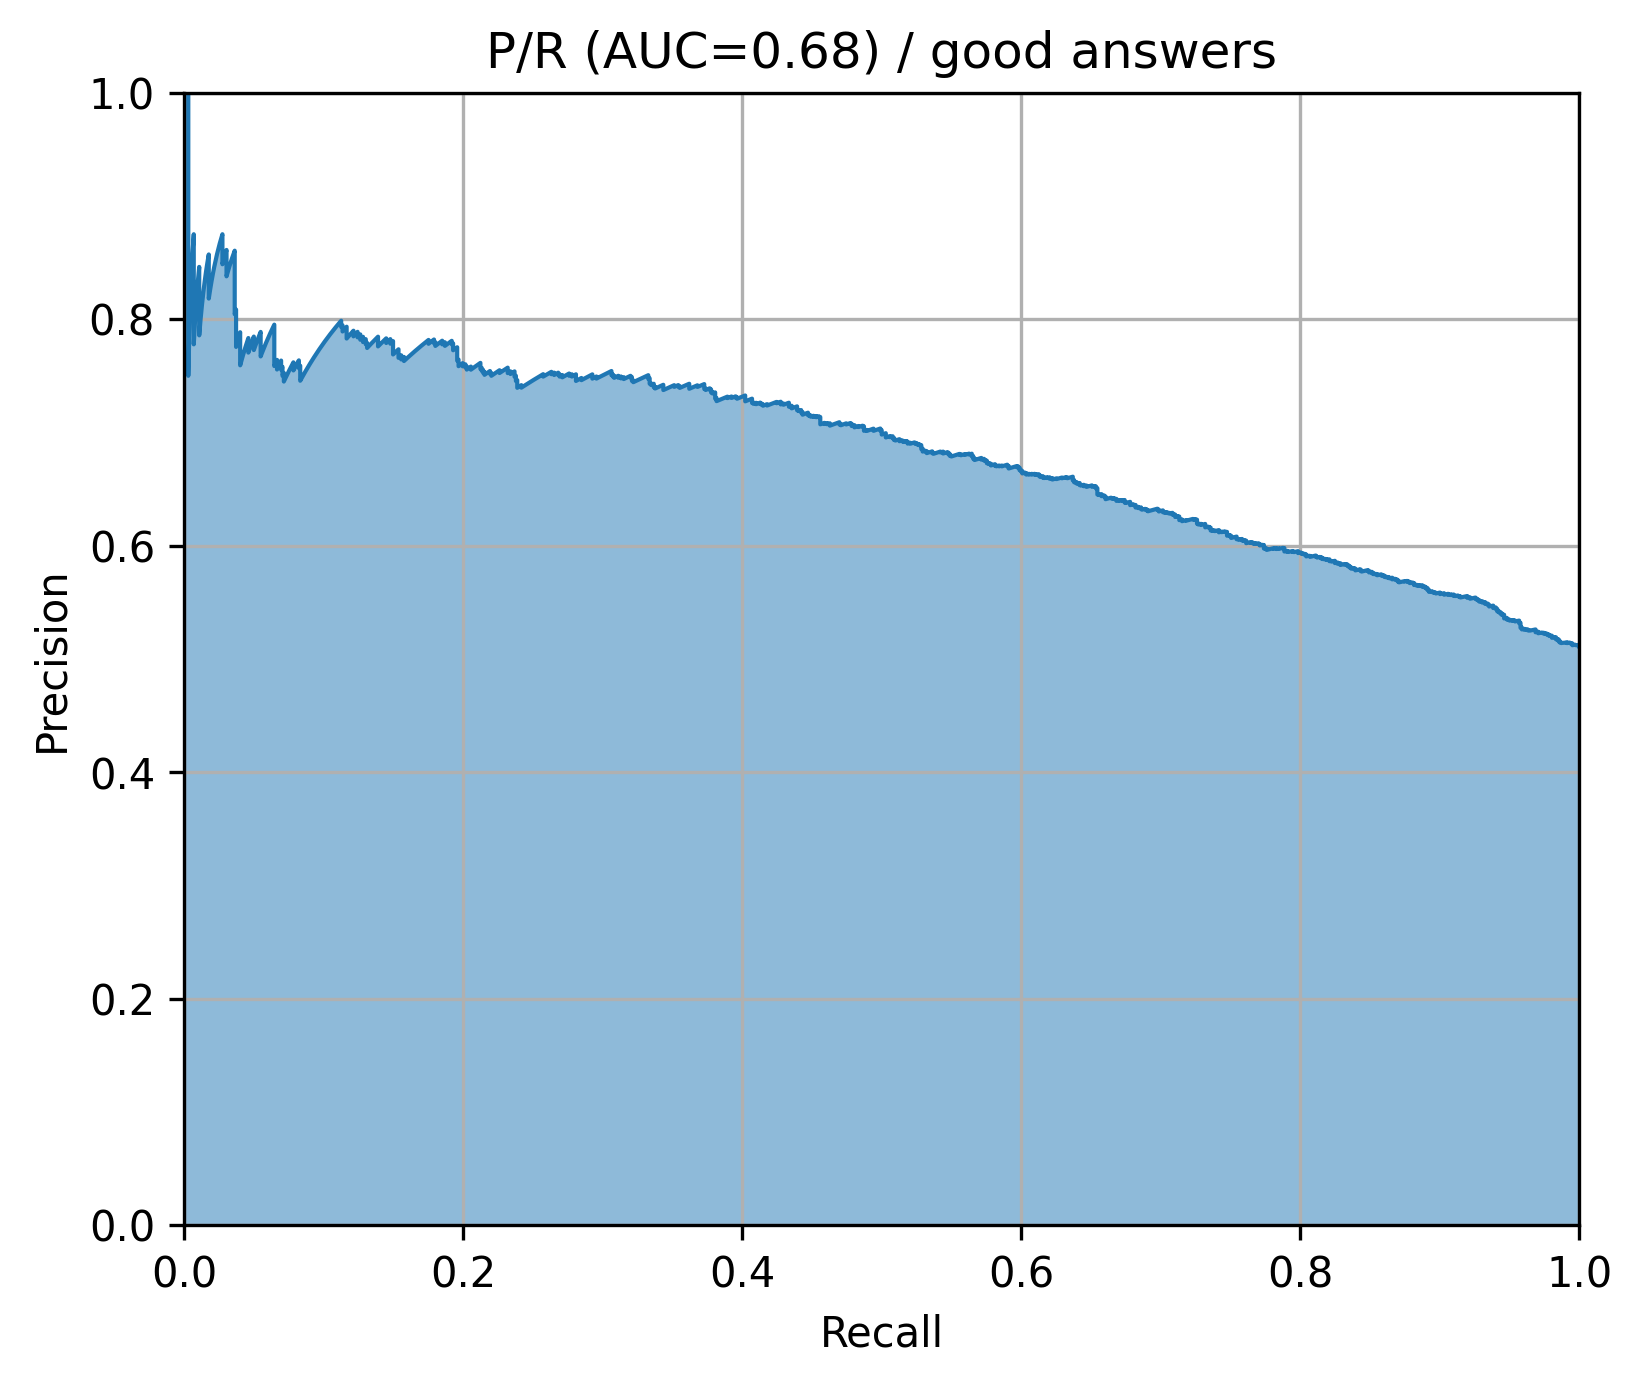

In [25]:
feature_names = np.array((
    'NumTextTokens',
    'NumCodeLines',
    'LinkCount',
    'AvgSentLen',
    'AvgWordLen',
    'NumAllCaps',
    'NumExclams'
))

X_orig = np.asarray([get_features(aid, ['LinkCount', 'NumCodeLines', 'NumTextTokens', 'AvgSentLen', 'AvgWordLen', 'NumAllCaps', 'NumExclams']) for aid in all_answers])

Y_orig_good = np.asarray([meta[aid]['Score'] > 0 for aid in all_answers])
Y_orig_poor = np.asarray([meta[aid]['Score'] <= 0 for aid in all_answers])

X_new, Y_good, Y_poor = shuffle(X_orig, Y_orig_good, Y_orig_poor, random_state=0)
    
name = "LogReg C={:.2f}".format(C_best)

print("Good answers...")
_, _, good_results = measure(LogisticRegression, {'C': C_best, 'max_iter': 200}, '08_good_'+name, X_new, Y_good, plot='good', feature_names=feature_names)

Poor answers...


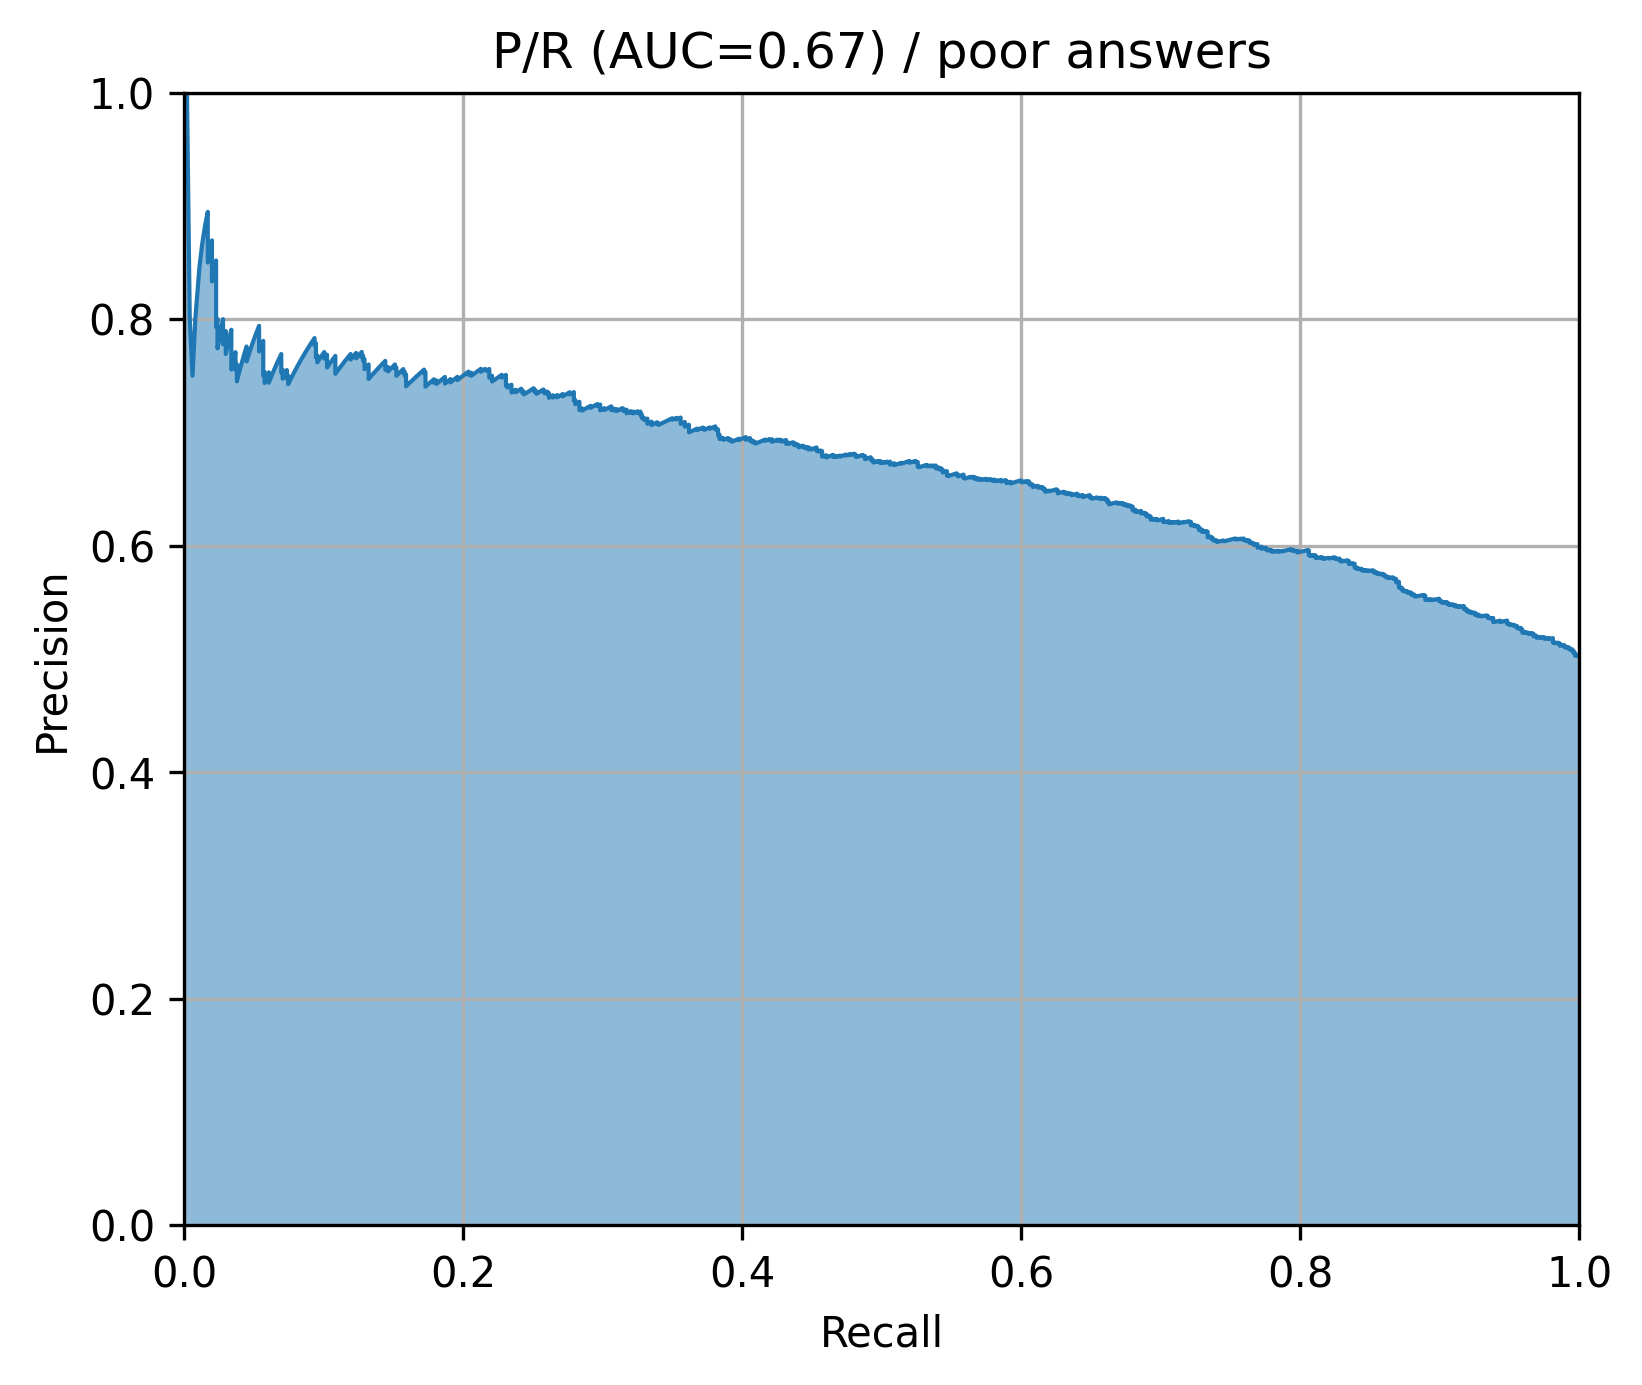

In [26]:
print("Poor answers...")
measure(LogisticRegression, {'C': C_best, 'max_iter': 200}, '09_poor_'+name, X_new, Y_poor, plot='poor', feature_names=feature_names);

So, how to optimize for precision? Some things that can be done now is count the number of TP, FP, and FN while that threshold is varied between 0 and 1. With those counts, precision over recall can be then plotted.

The handy precision_recall_curve() function from the metrics module does all the calculations:

Predicting one class with acceptable performance does not always mean that the classifier is also acceptable at predicting the other class. This can be seen in the following two plots, where the precision/recall curves are plotted for classifying bad (the first graph) and good (the second graph) answers:

In the graphs, a much better description of a classifier's performance has been also included, the area under curve (AUC). It can be understood as the average precision of the classifier and is a great way of comparing different classifiers.

Predicting good answers shows that 80% precision can be obtained at a recall of 10%, while only less than 3% recall is obtained when choosing to achieve 80% prediction on poor answers.

Find out what threshold is needed for that. As many classifiers are trained on different folds (remember, it was iterated over KFold() a couple of pages back), the classifier that was neither too bad nor too good needs to be retrieved in order to get a realistic view. Call it the medium clone:

In [27]:
precisions = good_results['med_precisions']
recalls = good_results['med_recalls']
thresholds = np.hstack([[0], good_results['med_thresholds']])

for precision in np.arange(0.77, 0.8, 0.01):
    thresh_idx = precisions >= precision
    print("P={:.2f} R={:.2f} thresh={:.2f}".format(precisions[thresh_idx][0], recalls[thresh_idx][0], thresholds[thresh_idx][0]))


P=0.77 R=0.20 thresh=0.66
P=0.78 R=0.19 thresh=0.67
P=0.79 R=0.12 thresh=0.77
P=0.81 R=0.04 thresh=0.92


Setting the threshold at 0.66, it can be seen that a precision of 77% at detecting good answers can be still achieved when a low recall of 20% is accepted. That means that one in three good answers would be detected only. But from that third of good answers'd manage to be detected, it would be reasonably sure that they are indeed good. For the rest, additional hints on how to improve answers in general could be then politely displayed.

# Slimming the classifier

It is always worth looking at the actual contributions of the individual features. For logistic regression, the learned coefficients (clf.coef_) can be directly taken to get an impression of the features' impact:

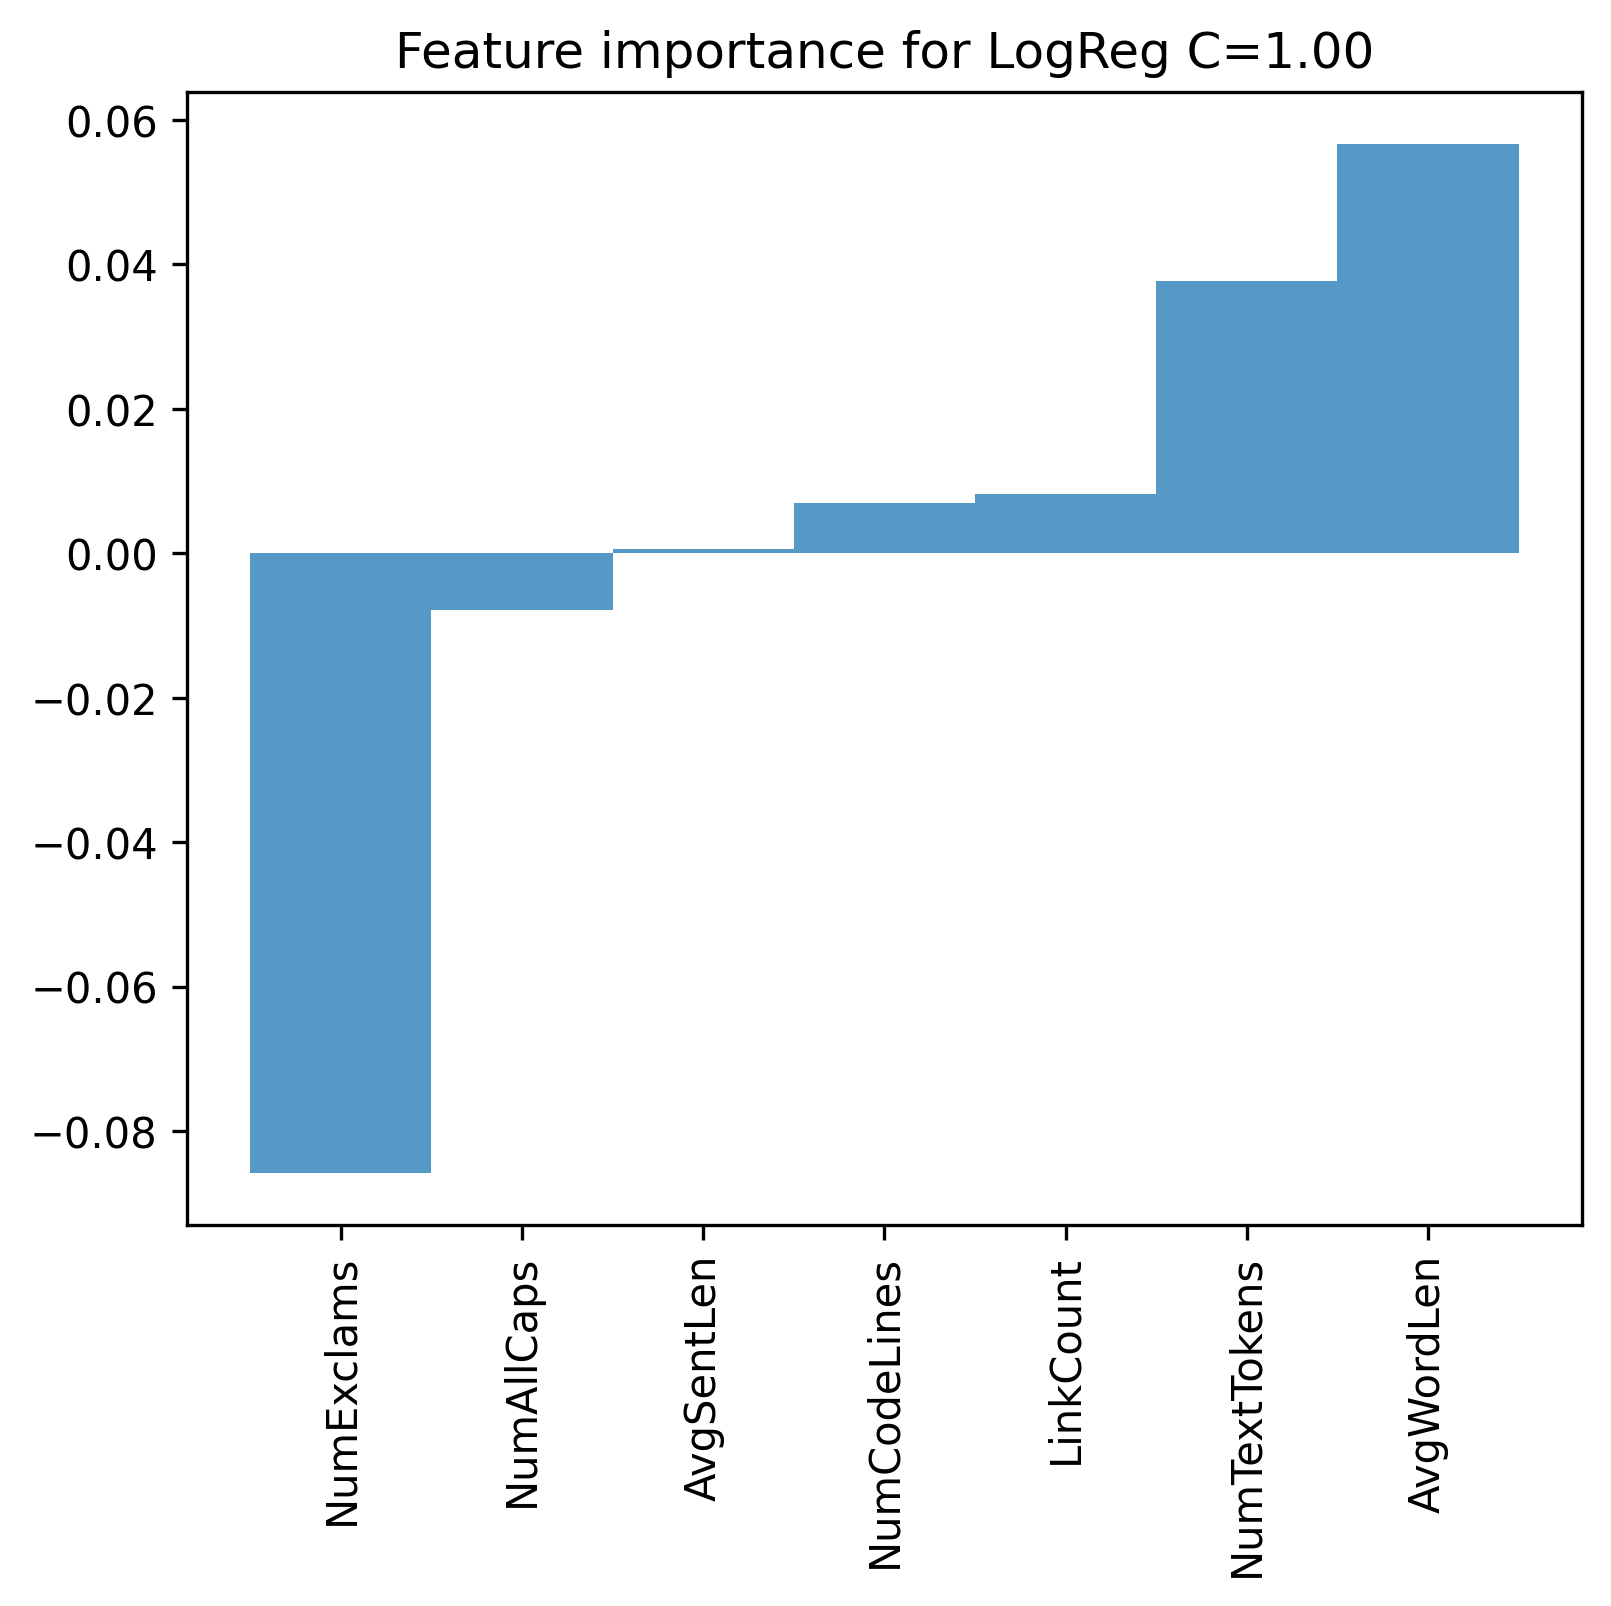

In [28]:
_, _, _ = measure(LogisticRegression, {'C': C_best, 'max_iter': 200}, name, X_new, Y_good, plot='feat_importance', feature_names=feature_names)

See that NumCodeLines, LinkCount, NumTextTokens and AvgWordLen have the highest positive impact on determining whether a post is a good one, while NumTextTokens, LinkCount, and NumCodeLines have a say in that as well, but much less so. This means that being more verbose will more likely result in a classification as a good answer.

On the other side, there are NumExclams and NumAllCaps have negative weights one. That means that the more an answer is shouting, the less likely it will be received well

Then there is the AvgSentLen feature, which does not seem to help much in detecting a good answer. However, just from the same classification performance magnitude of the coefficients, the feature's importance cannot immediately  be derived, because the classifier was trained on the raw features, which were not normalized.

# Ship it!

Assume this classifier want to be integrated into the site. Assume that the data was all available data. In that case, the classifier should be retrained on all data:

In [29]:
C_best = 1.0 # determined above
clf = LogisticRegression(C=C_best, max_iter=200)
clf.fit(X, Y) # now trainining an all data without cross-validation
print(clf.coef_)

[[ 0.04341749  0.0069945   0.00815925  0.00047563  0.06057145 -0.00466588
  -0.09454209]]


Finally, the trained classifier should be stored, because it definitely is not retrained each time the classification service is started. Instead, the classifier can be simply serialized after training and then deserialized on that site:

In [30]:
import pickle

pickle.dump(clf, open("logreg.dat", "wb"))
clf = pickle.load(open("logreg.dat", "rb"))
print(clf.coef_) # showing that the same classifier was indeed loaded again

[[ 0.04341749  0.0069945   0.00815925  0.00047563  0.06057145 -0.00466588
  -0.09454209]]


Congratulations, the classifier is now ready to be used as if it had just been trained. The classifier's predict_proba() can be now used to calculate the probability of an answer being a good one. the threshold of 0.66 will be used, which results in 77% precision at 20% recall, as it was determined earlier:

In [31]:
good_thresh = 0.66

Take a look at the features of two artificial posts to show how it works:

In [32]:
# Remember that the features are in this order:
# LinkCount, NumCodeLines, NumTextTokens, AvgSentLen, AvgWordLen,
# NumAllCaps, NumExclams
good_post = (2, 1, 100, 5, 12, 1, 0)
poor_post = (1, 0, 10, 5, 12, 5, 4)
proba = clf.predict_proba([good_post, poor_post])
print(proba) # print probabilities (poor, good) per post
print(proba >= good_thresh)

[[0.31305007 0.68694993]
 [0.59764891 0.40235109]]
[[False  True]
 [False False]]


As expected, the first post is managed to be detected as good, but cannot be said anything about the second, which is why a nice, motivating message would be shown directing the writer to improve the post.

# Classification using Tensorflow

Neural networks can also be designed to classify data. As with the previous classifier, they can generate a probability of belonging to a class, and as such, the required threshold can be used for the required precision.

This example will be the first real dive into neural networks. Instead of explicitly setting variables, standard Tensorflow functions will be used to create them.

Just as before, the same data will be used with all the current features:

In [33]:
X = np.asarray([get_features(aid, [
    'LinkCount',
    'NumCodeLines',
    'NumTextTokens',
    'AvgSentLen',
    'AvgWordLen',
    'NumAllCaps',
    'NumExclams'
]) for aid in all_answers])
Y = np.asarray([meta[aid]['Score'] > 0 for aid in all_answers])

Of course, an exercise here is to replicate previous results by using fewer features and see how this neural network will be able to discriminate between good and bad posts.

Neural networks are not the same as the brain. Layers is explicitly created, when in reality no such thing exists (more on this later, but this is required to understand how a simple neural network is created). It is a good practice to factor out the layers to create, so, for instance, two types of layers will be created: one for dense layers, meaning that they connect all input to all output, and one for the output layer that has only one output unit:

In [34]:
import tensorflow as tf

def create_dense(x, n_units):
    # Hidden layer
    x = tf.keras.layers.Dense(n_units)(x)
    h = tf.keras.layers.LeakyReLU()(x)
    return h

def create_output(x):
    # Output layer
    h = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    return h

This output unit is created with a sigmoid activation. This means that the inner tf.matmult that creates values between -inf and +inf is fed inside a function that maps these to the interval [0, 1]. 0 and 1 cannot be achieved for the output, so when the neural network is trained, this has to be kept in memory. As such, for the target probability in the training, the output is changed to accommodate this impossibility:

In [35]:
Y = Y.astype(np.float32)[:, None]
bce_ceil = 1e-5
Y = Y * (1 - 2 * bce_ceil) + bce_ceil

And now, we can split our data:

In [36]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8)

Start with setting our usual hyper parameters:

In [37]:
n_epochs = 500
batch_size = 1000
steps = 10
layer1_size = 5

If all seven features are used, the neural network building looks like this:

In [38]:
inputs = tf.keras.Input(shape=(X.shape[1],))
h1 = create_dense(inputs, layer1_size)
Y_tf = create_output(h1)
model = tf.keras.Model(inputs=inputs, outputs=Y_tf)

def loss(Y, model_output):
    return tf.reduce_mean(tf.square(Y - model_output))

grad_speed = .01
my_opt = tf.keras.optimizers.SGD(learning_rate=grad_speed)

def train_step(X, Y):
    with tf.GradientTape() as tape:
        Y_tf = model(X, training=True)
        square_loss = loss(Y, Y_tf)
    gradients = tape.gradient(square_loss, model.trainable_weights)
    my_opt.apply_gradients(zip(gradients, model.trainable_weights))
    return square_loss

The gradient step is now far greater than the one from the regression example. A smaller step could be used, but this would require more steps to achieve a local minimum of the loss function.

The neural network can be now trained, very similar to [Chapter2](https://github.com/robitalhazmi/machine-learning/blob/main/Chapter02/chapter_02.ipynb). The only difference is that at the end, the test data is also run inside
the neural network:

In [39]:
loss_vec = []
for epoch in range(n_epochs):
    permut = np.random.permutation(len(X_train))
    for j in range(0, len(X_train), batch_size):
        batch = permut[j:j+batch_size]
        Xs = X_train[batch]
        Ys = Y_train[batch]
        
        temp_loss = train_step(Xs, Ys)
    
    loss_vec.append(temp_loss)
    if epoch % steps == steps - 1:
        print('Epoch #{}  loss = {}'.format(epoch, temp_loss))

predict_train = model(X_train, training=False)
predict_test = model(X_test, training=False)

Epoch #9  loss = 0.49863240122795105
Epoch #19  loss = 0.5017065405845642
Epoch #29  loss = 0.5070011019706726
Epoch #39  loss = 0.4949389696121216
Epoch #49  loss = 0.5167290568351746
Epoch #59  loss = 0.49815478920936584
Epoch #69  loss = 0.5258200764656067
Epoch #79  loss = 0.4758131206035614
Epoch #89  loss = 0.5089948177337646
Epoch #99  loss = 0.5016189813613892
Epoch #109  loss = 0.5181217193603516
Epoch #119  loss = 0.4917443096637726
Epoch #129  loss = 0.4971337914466858
Epoch #139  loss = 0.5038992166519165
Epoch #149  loss = 0.5013231039047241
Epoch #159  loss = 0.30922725796699524
Epoch #169  loss = 0.2827087938785553
Epoch #179  loss = 0.2625918686389923
Epoch #189  loss = 0.23667822778224945
Epoch #199  loss = 0.2357386350631714
Epoch #209  loss = 0.2471339851617813
Epoch #219  loss = 0.23120667040348053
Epoch #229  loss = 0.23656238615512848
Epoch #239  loss = 0.23674710094928741
Epoch #249  loss = 0.2352069616317749
Epoch #259  loss = 0.21801191568374634
Epoch #269  los

For now, the neural network is thrown away.

Of course, how well the optimizer behaved can be also displayed:

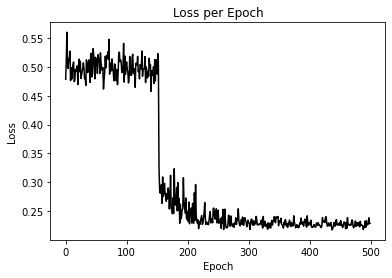

In [40]:
plt.plot(loss_vec, 'k-')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

The loss per generation can be very different from one run to another. grad_speed is the most important parameter that changes this graph. Its value is a compromise between convergence speed and stability, and an advice to try different values to see how this function behaves with different values and different runs.

If look at the scores for the training and the test scores, it can be seen that results that match the best of the previous classifiers are obtained:

In [41]:
from sklearn.metrics import accuracy_score

score = accuracy_score(Y_train > .5, predict_train > .5)
print("Score (on training data): {:.2f}".format(score))
score = accuracy_score(Y_test > .5, predict_test > .5)
print("Score (on testing data): {:.2f}".format(score))

Score (on training data): 0.63
Score (on testing data): 0.64


It is a good time to go back to the hyper parameters, especially the size of the intermediate or hidden layer and modify the number of nodes. Is lowering it degrading the classifier's behavior? Is increasing it improving it? What about adding another intermediate layer? What is the impact of its number of neurons?

A nice feature of sklearn is the abundance of support functions and tutorials. This is a function from a tutorial on confusion matrices that helps visualize the quality of a classifier:

In [42]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = (cm.max() - cm.min()) / 2 + cm.min()
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

It can be now used with a threshold at .5 to see the behavior of this classifier on trained and tested data:

              precision    recall  f1-score   support

        Poor       0.60      0.78      0.68      7987
        Good       0.69      0.48      0.57      8013

    accuracy                           0.63     16000
   macro avg       0.64      0.63      0.62     16000
weighted avg       0.64      0.63      0.62     16000

Confusion matrix, without normalization
[[6243 1744]
 [4169 3844]]


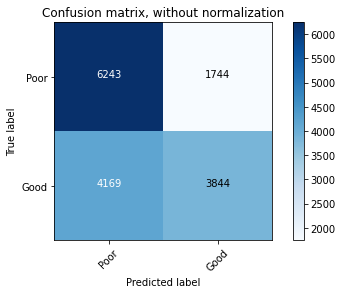

              precision    recall  f1-score   support

        Poor       0.61      0.79      0.69      2013
        Good       0.69      0.48      0.57      1987

    accuracy                           0.64      4000
   macro avg       0.65      0.64      0.63      4000
weighted avg       0.65      0.64      0.63      4000

Confusion matrix, without normalization
[[1590  423]
 [1028  959]]


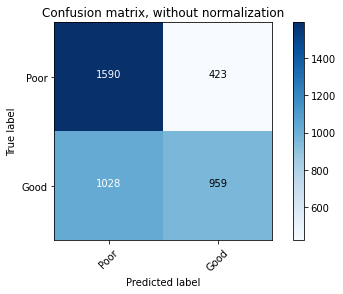

In [43]:
class_names = ["Poor", "Good"]

from sklearn import metrics

print(metrics.classification_report(Y_train > .5, predict_train > .5, target_names=class_names))
plot_confusion_matrix(metrics.confusion_matrix(Y_train > .5, predict_train > .5), classes=class_names,title='Confusion matrix, without normalization')
print(metrics.classification_report(Y_test > .5, predict_test > .5, target_names=class_names))
plot_confusion_matrix(metrics.confusion_matrix(Y_test > .5, predict_test > .5), classes=class_names,title='Confusion matrix, without normalization')

It is very interesting to see the stability of the classifier when moving from training data to test data. In both cases, it can be also seen that there are still lots of misclassifications, with an emphasis on good posts that were labeled as bad posts (which is probably better than the opposite!).